In [2]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split  
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [6]:
class CustomDataset(Dataset):
    def __init__(self, file_path, x_size):
        df = pd.read_csv(file_path)

        self.x = df.iloc[x_size:, 6:10].values
        #self.x = np.reshape(x, (x.shape[0], 1, x.shape[1]))

        self.y = df.iloc[x_size:, 13:14].values
        
        self.length = len(df) - x_size

    #getitem이거 왜씀?
    def __getitem__(self, index):
        # x = torch.FloatTensor([self.x[index]])
        # y = torch.FloatTensor([self.y[index]])
        # return x, y
        feature = torch.FloatTensor([self.x[index]])
        label = torch.FloatTensor(self.y[index])

        return feature, label

    def __len__(self):
        return self.length

In [7]:
dataset_d = CustomDataset("DST_80.csv", 1919) #1919
dataset_f = CustomDataset("FUDS_80.csv", 2586) #2586
dataset_u = CustomDataset("US06_80.csv", 1207) #1207
print(dataset_d.x.shape)
print(dataset_d.y.shape)
print(dataset_f.x.shape)
print(dataset_f.y.shape)
print(dataset_u.x.shape)
print(dataset_u.y.shape)
print(dataset_d)
print(len(dataset_d))
print(len(dataset_f))
print(len(dataset_u))

(10639, 4)
(10639, 1)
(11095, 4)
(11095, 1)
(10690, 4)
(10690, 1)
10639
11095
10690


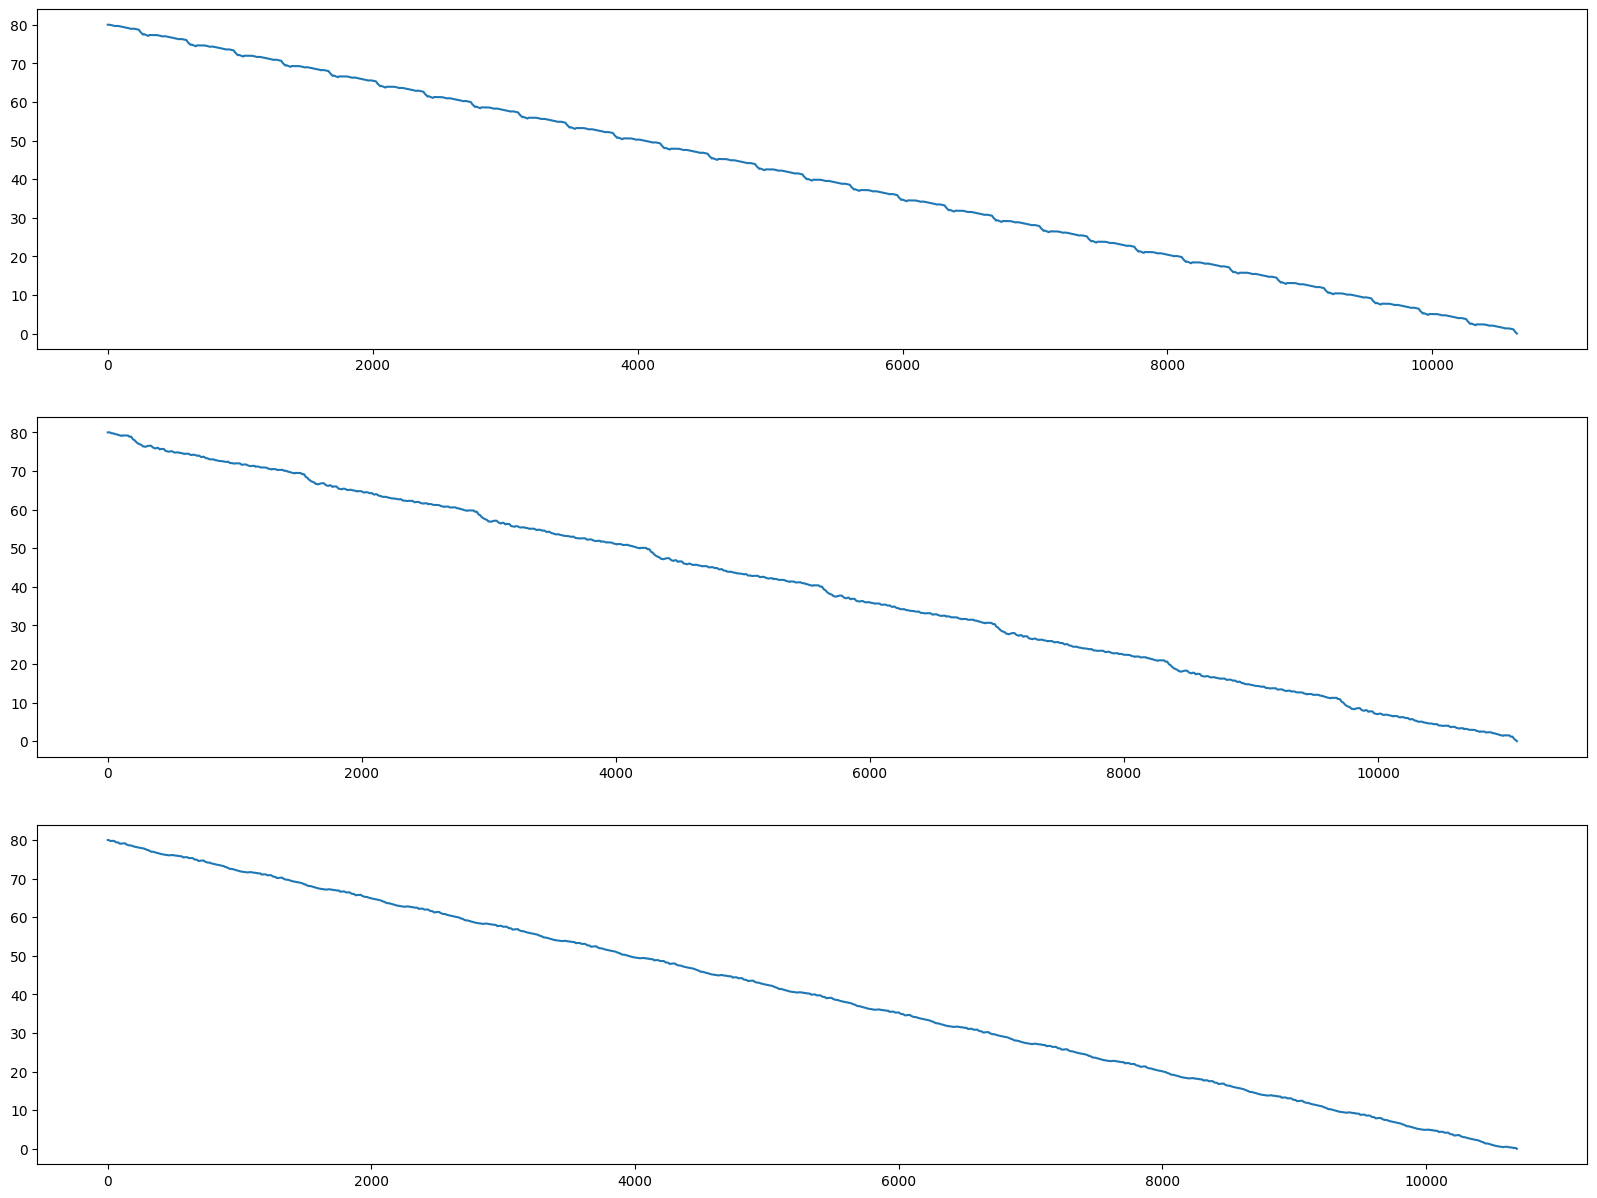

In [4]:
plt.figure(figsize=(20,15))
plt.subplot(3,1,1)
plt.plot(dataset_d.y)
plt.subplot(3,1,2)
plt.plot(dataset_f.y)
plt.subplot(3,1,3)
plt.plot(dataset_u.y)
plt.show()

In [5]:
dataset = torch.utils.data.ConcatDataset([dataset_d, dataset_f, dataset_u]) #x,y 어떻게된지 모름

train_dataset, test_dataset = random_split(dataset, [len(dataset_d)+len(dataset_f), len(dataset_u)])

In [6]:
print(len(dataset_d))
print(len(dataset_f))
print(len(dataset_u))
print(len(dataset_d)+len(dataset_f))

10639
11095
10690
21734


In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False, drop_last=False)
#validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=False)

In [8]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes 
        self.num_layers = num_layers 
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.seq_length = seq_length 

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) 
        self.fc_1 =  nn.Linear(hidden_size, 128)
        self.batchnormal = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128, num_classes) 

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) 
        hn = hn.view(-1, self.hidden_size) 
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [9]:
num_epochs = 100
learning_rate = 0.001

input_size = 4
hidden_size = 64
num_layers = 1 

num_classes = 1

model = LSTM(num_classes, input_size, hidden_size, num_layers, 4)
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
def train_loop(model, dataloader, loss_func, optimizer):
    model.train()
    size = len(dataloader.dataset)
    print("Training")
    running_loss = 0.
    last_loss = 0.

    for batch, (x,y) in tqdm(enumerate(dataloader)):
        pred = model(x)
        loss = loss_func(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [11]:
def test_loop(model, dataloader, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [12]:
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(model, train_dataloader, loss_func, optimizer)
    test_loop(model, test_dataloader, loss_func)
print("Done!")

Epoch 1
-------------------------------
Training


0it [00:00, ?it/s]C:\Users\USER\AppData\Local\Temp\ipykernel_5732\1241854177.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  feature = torch.FloatTensor([self.x[index]])
25it [00:00, 247.53it/s]

loss: 2187.671143  [   16/21734]


82it [00:00, 433.84it/s]

loss: 503.288574  [ 1616/21734]

126it [00:00, 390.49it/s]

281it [00:00, 489.30it/s]

loss: 486.342224  [ 3216/21734]
loss: 465.051361  [ 4816/21734]


524it [00:01, 586.19it/s]

loss: 199.706528  [ 6416/21734]
loss: 40.992794  [ 8016/21734]


725it [00:01, 641.14it/s]

loss: 6.635405  [ 9616/21734]
loss: 1.507433  [11216/21734]


852it [00:01, 573.94it/s]

loss: 1.395791  [12816/21734]


968it [00:01, 549.09it/s]

loss: 0.828219  [14416/21734]
loss: 0.849709  [16016/21734]


1210it [00:02, 598.15it/s]

loss: 1.075451  [17616/21734]
loss: 0.512447  [19216/21734]


1359it [00:02, 555.75it/s]


loss: 0.353214  [20816/21734]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.885675 

Epoch 2
-------------------------------
Training


66it [00:00, 656.65it/s]

loss: 0.823668  [   16/21734]
loss: 0.892050  [ 1616/21734]


261it [00:00, 627.57it/s]

loss: 0.851220  [ 3216/21734]
loss: 0.614404  [ 4816/21734]


517it [00:00, 617.74it/s]

loss: 0.738963  [ 6416/21734]
loss: 0.894015  [ 8016/21734]


713it [00:01, 634.68it/s]

loss: 1.093160  [ 9616/21734]
loss: 1.048585  [11216/21734]


904it [00:01, 624.20it/s]

loss: 1.027330  [12816/21734]
loss: 1.013969  [14416/21734]


1093it [00:01, 622.48it/s]

loss: 0.836640  [16016/21734]
loss: 1.057447  [17616/21734]


1288it [00:02, 633.38it/s]

loss: 0.676988  [19216/21734]
loss: 0.354288  [20816/21734]


1359it [00:02, 628.20it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.829830 

Epoch 3
-------------------------------
Training


63it [00:00, 623.77it/s]

loss: 0.852521  [   16/21734]
loss: 1.319780  [ 1616/21734]


258it [00:00, 644.06it/s]

loss: 0.670929  [ 3216/21734]
loss: 0.576846  [ 4816/21734]


454it [00:00, 644.46it/s]

loss: 0.769403  [ 6416/21734]
loss: 0.609581  [ 8016/21734]


713it [00:01, 636.70it/s]

loss: 1.061917  [ 9616/21734]
loss: 1.000514  [11216/21734]


908it [00:01, 642.20it/s]

loss: 1.032952  [12816/21734]
loss: 0.967849  [14416/21734]


1103it [00:01, 637.02it/s]

loss: 0.890568  [16016/21734]
loss: 0.952676  [17616/21734]


1297it [00:02, 634.49it/s]

loss: 0.762422  [19216/21734]
loss: 0.339533  [20816/21734]


1359it [00:02, 636.70it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.765322 

Epoch 4
-------------------------------
Training


66it [00:00, 659.97it/s]

loss: 0.812693  [   16/21734]
loss: 1.389174  [ 1616/21734]


328it [00:00, 646.50it/s]

loss: 0.626178  [ 3216/21734]
loss: 0.546847  [ 4816/21734]


462it [00:00, 657.46it/s]

loss: 0.863646  [ 6416/21734]
loss: 0.684232  [ 8016/21734]


728it [00:01, 647.26it/s]

loss: 0.788894  [ 9616/21734]
loss: 1.395937  [11216/21734]


858it [00:01, 643.45it/s]

loss: 1.023202  [12816/21734]
loss: 1.177655  [14416/21734]


1124it [00:01, 651.01it/s]

loss: 0.988925  [16016/21734]
loss: 0.963218  [17616/21734]


1324it [00:02, 656.11it/s]

loss: 0.726598  [19216/21734]
loss: 0.293357  [20816/21734]


1359it [00:02, 649.46it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.741126 

Epoch 5
-------------------------------
Training


66it [00:00, 653.47it/s]

loss: 0.801317  [   16/21734]
loss: 1.269241  [ 1616/21734]


263it [00:00, 586.18it/s]

loss: 0.726146  [ 3216/21734]
loss: 0.550560  [ 4816/21734]


453it [00:00, 609.47it/s]

loss: 0.868213  [ 6416/21734]
loss: 0.609866  [ 8016/21734]


704it [00:01, 610.69it/s]

loss: 0.730046  [ 9616/21734]
loss: 1.450757  [11216/21734]


897it [00:01, 628.23it/s]

loss: 1.011069  [12816/21734]
loss: 1.173145  [14416/21734]


1096it [00:01, 646.17it/s]

loss: 1.085467  [16016/21734]
loss: 0.976174  [17616/21734]


1295it [00:02, 647.63it/s]

loss: 0.741229  [19216/21734]
loss: 0.270918  [20816/21734]


1359it [00:02, 626.66it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.732362 

Epoch 6
-------------------------------
Training


66it [00:00, 653.47it/s]

loss: 0.778006  [   16/21734]
loss: 1.105325  [ 1616/21734]


323it [00:00, 614.00it/s]

loss: 0.715221  [ 3216/21734]
loss: 0.531679  [ 4816/21734]


515it [00:00, 631.39it/s]

loss: 0.869496  [ 6416/21734]
loss: 0.607260  [ 8016/21734]


704it [00:01, 609.55it/s]

loss: 0.686957  [ 9616/21734]
loss: 1.465996  [11216/21734]


885it [00:01, 581.36it/s]

loss: 1.050027  [12816/21734]
loss: 1.176876  [14416/21734]


1068it [00:01, 565.63it/s]

loss: 1.103834  [16016/21734]
loss: 0.993301  [17616/21734]


1324it [00:02, 613.21it/s]

loss: 0.765967  [19216/21734]
loss: 0.274773  [20816/21734]


1359it [00:02, 602.93it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.710955 

Epoch 7
-------------------------------
Training


61it [00:00, 603.86it/s]

loss: 0.726188  [   16/21734]
loss: 0.909151  [ 1616/21734]


259it [00:00, 641.87it/s]

loss: 0.723990  [ 3216/21734]
loss: 0.517815  [ 4816/21734]


516it [00:00, 623.55it/s]

loss: 0.917036  [ 6416/21734]
loss: 0.602541  [ 8016/21734]


708it [00:01, 625.61it/s]

loss: 0.662870  [ 9616/21734]
loss: 1.443889  [11216/21734]


902it [00:01, 622.51it/s]

loss: 1.034100  [12816/21734]
loss: 1.148651  [14416/21734]


1091it [00:01, 622.22it/s]

loss: 1.080515  [16016/21734]
loss: 0.926850  [17616/21734]


1283it [00:02, 626.18it/s]

loss: 0.733013  [19216/21734]
loss: 0.261571  [20816/21734]


1359it [00:02, 624.42it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.683012 

Epoch 8
-------------------------------
Training


65it [00:00, 637.26it/s]

loss: 0.679000  [   16/21734]
loss: 0.884085  [ 1616/21734]


324it [00:00, 642.58it/s]

loss: 0.699215  [ 3216/21734]
loss: 0.492311  [ 4816/21734]


457it [00:00, 601.46it/s]

loss: 0.871431  [ 6416/21734]
loss: 0.585757  [ 8016/21734]


717it [00:01, 633.71it/s]

loss: 0.610928  [ 9616/21734]
loss: 1.451967  [11216/21734]


913it [00:01, 640.08it/s]

loss: 0.980135  [12816/21734]
loss: 1.034843  [14416/21734]


1108it [00:01, 634.68it/s]

loss: 1.027499  [16016/21734]
loss: 0.908504  [17616/21734]


1302it [00:02, 635.00it/s]

loss: 0.668823  [19216/21734]
loss: 0.273725  [20816/21734]


1359it [00:02, 631.95it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.643548 

Epoch 9
-------------------------------
Training


65it [00:00, 648.12it/s]

loss: 0.651784  [   16/21734]
loss: 0.856963  [ 1616/21734]


260it [00:00, 630.47it/s]

loss: 0.680857  [ 3216/21734]
loss: 0.432866  [ 4816/21734]


519it [00:00, 644.93it/s]

loss: 0.809971  [ 6416/21734]
loss: 0.574215  [ 8016/21734]


719it [00:01, 655.81it/s]

loss: 0.573492  [ 9616/21734]
loss: 1.390803  [11216/21734]


916it [00:01, 645.78it/s]

loss: 0.944553  [12816/21734]
loss: 0.940819  [14416/21734]


1114it [00:01, 653.61it/s]

loss: 0.854331  [16016/21734]
loss: 0.798191  [17616/21734]


1311it [00:02, 615.85it/s]

loss: 0.571206  [19216/21734]
loss: 0.261726  [20816/21734]


1359it [00:02, 636.58it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.576154 

Epoch 10
-------------------------------
Training


60it [00:00, 594.06it/s]

loss: 0.618012  [   16/21734]
loss: 0.808697  [ 1616/21734]


315it [00:00, 635.69it/s]

loss: 0.659633  [ 3216/21734]
loss: 0.393697  [ 4816/21734]


512it [00:00, 641.49it/s]

loss: 0.688083  [ 6416/21734]
loss: 0.470617  [ 8016/21734]


711it [00:01, 653.55it/s]

loss: 0.491534  [ 9616/21734]
loss: 1.279325  [11216/21734]


914it [00:01, 663.73it/s]

loss: 0.847904  [12816/21734]
loss: 0.838078  [14416/21734]


1114it [00:01, 654.19it/s]

loss: 0.790823  [16016/21734]
loss: 0.652982  [17616/21734]


1316it [00:02, 651.90it/s]

loss: 0.428879  [19216/21734]
loss: 0.228906  [20816/21734]


1359it [00:02, 645.96it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.505834 

Epoch 11
-------------------------------
Training


65it [00:00, 643.56it/s]

loss: 0.527050  [   16/21734]
loss: 0.660800  [ 1616/21734]


324it [00:00, 636.11it/s]

loss: 0.791255  [ 3216/21734]
loss: 0.304048  [ 4816/21734]


455it [00:00, 549.30it/s]

loss: 0.545866  [ 6416/21734]


584it [00:00, 592.96it/s]

loss: 0.549856  [ 8016/21734]
loss: 0.405630  [ 9616/21734]


775it [00:01, 611.32it/s]

loss: 1.185266  [11216/21734]
loss: 0.779828  [12816/21734]


972it [00:01, 630.38it/s]

loss: 0.735436  [14416/21734]
loss: 0.703021  [16016/21734]


1167it [00:01, 637.01it/s]

loss: 0.588833  [17616/21734]
loss: 0.277929  [19216/21734]


1359it [00:02, 616.45it/s]


loss: 0.177365  [20816/21734]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.429653 

Epoch 12
-------------------------------
Training


65it [00:00, 643.56it/s]

loss: 0.400264  [   16/21734]
loss: 0.482590  [ 1616/21734]


270it [00:00, 659.97it/s]

loss: 0.771507  [ 3216/21734]
loss: 0.232484  [ 4816/21734]


473it [00:00, 666.09it/s]

loss: 0.414083  [ 6416/21734]
loss: 0.498586  [ 8016/21734]


673it [00:01, 659.23it/s]

loss: 0.341344  [ 9616/21734]
loss: 1.094718  [11216/21734]


870it [00:01, 633.93it/s]

loss: 0.687135  [12816/21734]
loss: 0.562693  [14416/21734]


1067it [00:01, 645.25it/s]

loss: 0.538808  [16016/21734]
loss: 0.509470  [17616/21734]


1270it [00:01, 633.33it/s]

loss: 0.230283  [19216/21734]
loss: 0.151434  [20816/21734]


1359it [00:02, 648.01it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.382389 

Epoch 13
-------------------------------
Training


65it [00:00, 643.57it/s]

loss: 0.313877  [   16/21734]
loss: 0.347933  [ 1616/21734]


266it [00:00, 648.16it/s]

loss: 0.743892  [ 3216/21734]
loss: 0.173908  [ 4816/21734]


465it [00:00, 650.18it/s]

loss: 0.307653  [ 6416/21734]
loss: 0.357601  [ 8016/21734]


730it [00:01, 652.26it/s]

loss: 0.281940  [ 9616/21734]
loss: 0.920537  [11216/21734]


932it [00:01, 658.88it/s]

loss: 0.580090  [12816/21734]
loss: 0.386175  [14416/21734]


1062it [00:01, 615.26it/s]

loss: 0.417032  [16016/21734]
loss: 0.376033  [17616/21734]


1257it [00:01, 637.55it/s]

loss: 0.208438  [19216/21734]
loss: 0.127427  [20816/21734]


1359it [00:02, 644.62it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.409545 

Epoch 14
-------------------------------
Training


62it [00:00, 619.99it/s]

loss: 0.364014  [   16/21734]
loss: 0.202727  [ 1616/21734]


309it [00:00, 606.31it/s]

loss: 0.494381  [ 3216/21734]
loss: 0.168785  [ 4816/21734]


494it [00:00, 577.45it/s]

loss: 0.267724  [ 6416/21734]
loss: 0.183940  [ 8016/21734]


674it [00:01, 548.50it/s]

loss: 0.218824  [ 9616/21734]
loss: 0.503502  [11216/21734]


919it [00:01, 593.21it/s]

loss: 0.478000  [12816/21734]
loss: 0.266305  [14416/21734]


1110it [00:01, 607.51it/s]

loss: 0.253137  [16016/21734]
loss: 0.255953  [17616/21734]


1299it [00:02, 604.70it/s]

loss: 0.217118  [19216/21734]
loss: 0.096351  [20816/21734]


1359it [00:02, 590.58it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.433447 

Epoch 15
-------------------------------
Training


63it [00:00, 626.78it/s]

loss: 0.380893  [   16/21734]
loss: 0.151291  [ 1616/21734]


256it [00:00, 637.37it/s]

loss: 0.238452  [ 3216/21734]
loss: 0.109110  [ 4816/21734]


508it [00:00, 615.44it/s]

loss: 0.236587  [ 6416/21734]
loss: 0.112695  [ 8016/21734]


691it [00:01, 599.32it/s]

loss: 0.137214  [ 9616/21734]
loss: 0.168615  [11216/21734]


882it [00:01, 616.87it/s]

loss: 0.260997  [12816/21734]
loss: 0.209983  [14416/21734]


1067it [00:01, 580.37it/s]

loss: 0.113760  [16016/21734]
loss: 0.166874  [17616/21734]


1307it [00:02, 592.38it/s]

loss: 0.133831  [19216/21734]
loss: 0.064172  [20816/21734]


1359it [00:02, 604.89it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.244005 

Epoch 16
-------------------------------
Training


64it [00:00, 639.83it/s]

loss: 0.170989  [   16/21734]
loss: 0.114905  [ 1616/21734]


256it [00:00, 634.44it/s]

loss: 0.133944  [ 3216/21734]
loss: 0.060945  [ 4816/21734]


452it [00:00, 639.31it/s]

loss: 0.176751  [ 6416/21734]
loss: 0.125521  [ 8016/21734]


713it [00:01, 645.42it/s]

loss: 0.089780  [ 9616/21734]
loss: 0.092985  [11216/21734]


909it [00:01, 643.91it/s]

loss: 0.150791  [12816/21734]
loss: 0.155504  [14416/21734]


1104it [00:01, 644.00it/s]

loss: 0.069465  [16016/21734]
loss: 0.162296  [17616/21734]


1302it [00:02, 646.18it/s]

loss: 0.074007  [19216/21734]
loss: 0.051220  [20816/21734]


1359it [00:02, 638.81it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.135476 

Epoch 17
-------------------------------
Training


66it [00:00, 653.43it/s]

loss: 0.064970  [   16/21734]
loss: 0.116478  [ 1616/21734]


258it [00:00, 603.10it/s]

loss: 0.089211  [ 3216/21734]
loss: 0.038357  [ 4816/21734]


510it [00:00, 626.40it/s]

loss: 0.122013  [ 6416/21734]
loss: 0.103932  [ 8016/21734]


703it [00:01, 635.02it/s]

loss: 0.056825  [ 9616/21734]
loss: 0.078742  [11216/21734]


899it [00:01, 647.53it/s]

loss: 0.109885  [12816/21734]
loss: 0.136409  [14416/21734]


1096it [00:01, 647.53it/s]

loss: 0.090709  [16016/21734]
loss: 0.065447  [17616/21734]


1295it [00:02, 650.57it/s]

loss: 0.061573  [19216/21734]
loss: 0.049148  [20816/21734]


1359it [00:02, 635.56it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.106325 

Epoch 18
-------------------------------
Training


67it [00:00, 666.60it/s]

loss: 0.073114  [   16/21734]
loss: 0.111493  [ 1616/21734]


267it [00:00, 634.98it/s]

loss: 0.048619  [ 3216/21734]
loss: 0.029160  [ 4816/21734]


464it [00:00, 597.63it/s]

loss: 0.061207  [ 6416/21734]
loss: 0.068016  [ 8016/21734]


724it [00:01, 639.12it/s]

loss: 0.062561  [ 9616/21734]
loss: 0.053731  [11216/21734]


923it [00:01, 653.68it/s]

loss: 0.049409  [12816/21734]
loss: 0.075076  [14416/21734]


1055it [00:01, 652.07it/s]

loss: 0.089763  [16016/21734]
loss: 0.085718  [17616/21734]


1252it [00:01, 639.15it/s]

loss: 0.050918  [19216/21734]
loss: 0.041584  [20816/21734]


1359it [00:02, 639.09it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.084242 

Epoch 19
-------------------------------
Training


63it [00:00, 628.42it/s]

loss: 0.088747  [   16/21734]
loss: 0.113692  [ 1616/21734]


252it [00:00, 604.46it/s]

loss: 0.040012  [ 3216/21734]
loss: 0.026329  [ 4816/21734]


513it [00:00, 644.34it/s]

loss: 0.042218  [ 6416/21734]
loss: 0.048243  [ 8016/21734]


710it [00:01, 649.02it/s]

loss: 0.034547  [ 9616/21734]
loss: 0.023716  [11216/21734]


910it [00:01, 659.22it/s]

loss: 0.045185  [12816/21734]
loss: 0.056682  [14416/21734]


1102it [00:01, 611.77it/s]

loss: 0.061748  [16016/21734]
loss: 0.073462  [17616/21734]


1297it [00:02, 632.40it/s]

loss: 0.151081  [19216/21734]
loss: 0.051582  [20816/21734]


1359it [00:02, 629.34it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.063088 

Epoch 20
-------------------------------
Training


65it [00:00, 644.13it/s]

loss: 0.065842  [   16/21734]
loss: 0.086505  [ 1616/21734]


263it [00:00, 652.34it/s]

loss: 0.025467  [ 3216/21734]
loss: 0.037178  [ 4816/21734]


523it [00:00, 635.39it/s]

loss: 0.033339  [ 6416/21734]
loss: 0.045147  [ 8016/21734]


715it [00:01, 633.61it/s]

loss: 0.024960  [ 9616/21734]
loss: 0.019653  [11216/21734]


906it [00:01, 621.97it/s]

loss: 0.041423  [12816/21734]
loss: 0.051265  [14416/21734]


1102it [00:01, 639.29it/s]

loss: 0.042591  [16016/21734]
loss: 0.055879  [17616/21734]


1302it [00:02, 644.23it/s]

loss: 0.144946  [19216/21734]
loss: 0.052483  [20816/21734]


1359it [00:02, 627.90it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.051354 

Epoch 21
-------------------------------
Training


66it [00:00, 659.99it/s]

loss: 0.052748  [   16/21734]
loss: 0.053222  [ 1616/21734]


327it [00:00, 642.97it/s]

loss: 0.019179  [ 3216/21734]
loss: 0.033637  [ 4816/21734]


457it [00:00, 636.69it/s]

loss: 0.034735  [ 6416/21734]
loss: 0.041783  [ 8016/21734]


717it [00:01, 642.29it/s]

loss: 0.024658  [ 9616/21734]
loss: 0.020623  [11216/21734]


921it [00:01, 662.67it/s]

loss: 0.039893  [12816/21734]
loss: 0.044427  [14416/21734]


1119it [00:01, 638.48it/s]

loss: 0.035264  [16016/21734]
loss: 0.044882  [17616/21734]


1313it [00:02, 636.75it/s]

loss: 0.122316  [19216/21734]
loss: 0.049464  [20816/21734]


1359it [00:02, 644.27it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.041434 

Epoch 22
-------------------------------
Training


125it [00:00, 625.14it/s]

loss: 0.043008  [   16/21734]
loss: 0.042403  [ 1616/21734]


242it [00:00, 493.69it/s]

loss: 0.014403  [ 3216/21734]


353it [00:00, 526.78it/s]

loss: 0.028069  [ 4816/21734]


459it [00:00, 492.53it/s]

loss: 0.034322  [ 6416/21734]
loss: 0.040740  [ 8016/21734]


707it [00:01, 589.07it/s]

loss: 0.026928  [ 9616/21734]
loss: 0.016714  [11216/21734]


898it [00:01, 618.62it/s]

loss: 0.033217  [12816/21734]
loss: 0.042846  [14416/21734]


1089it [00:01, 622.82it/s]

loss: 0.032710  [16016/21734]
loss: 0.033023  [17616/21734]


1283it [00:02, 637.15it/s]

loss: 0.079255  [19216/21734]
loss: 0.050517  [20816/21734]


1359it [00:02, 584.92it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.036152 

Epoch 23
-------------------------------
Training


67it [00:00, 662.98it/s]

loss: 0.037033  [   16/21734]
loss: 0.040215  [ 1616/21734]


338it [00:00, 662.98it/s]

loss: 0.013434  [ 3216/21734]
loss: 0.026433  [ 4816/21734]


472it [00:00, 614.34it/s]

loss: 0.030708  [ 6416/21734]
loss: 0.043750  [ 8016/21734]


671it [00:01, 643.01it/s]

loss: 0.027634  [ 9616/21734]
loss: 0.014993  [11216/21734]


873it [00:01, 654.49it/s]

loss: 0.035259  [12816/21734]
loss: 0.039541  [14416/21734]


1071it [00:01, 653.82it/s]

loss: 0.030947  [16016/21734]
loss: 0.028735  [17616/21734]


1268it [00:01, 647.55it/s]

loss: 0.064871  [19216/21734]
loss: 0.049170  [20816/21734]


1359it [00:02, 649.05it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.032511 

Epoch 24
-------------------------------
Training


67it [00:00, 670.00it/s]

loss: 0.035016  [   16/21734]
loss: 0.034719  [ 1616/21734]


268it [00:00, 654.46it/s]

loss: 0.012288  [ 3216/21734]
loss: 0.025530  [ 4816/21734]


471it [00:00, 659.43it/s]

loss: 0.025695  [ 6416/21734]
loss: 0.042275  [ 8016/21734]


673it [00:01, 653.85it/s]

loss: 0.032285  [ 9616/21734]
loss: 0.013422  [11216/21734]


870it [00:01, 646.03it/s]

loss: 0.033995  [12816/21734]
loss: 0.037253  [14416/21734]


1073it [00:01, 652.77it/s]

loss: 0.028727  [16016/21734]
loss: 0.024890  [17616/21734]


1274it [00:01, 653.83it/s]

loss: 0.057361  [19216/21734]
loss: 0.049463  [20816/21734]


1359it [00:02, 655.98it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.030078 

Epoch 25
-------------------------------
Training


62it [00:00, 610.79it/s]

loss: 0.033100  [   16/21734]
loss: 0.031432  [ 1616/21734]


323it [00:00, 630.13it/s]

loss: 0.012023  [ 3216/21734]
loss: 0.030125  [ 4816/21734]


515it [00:00, 632.44it/s]

loss: 0.022676  [ 6416/21734]
loss: 0.044806  [ 8016/21734]


707it [00:01, 630.88it/s]

loss: 0.030905  [ 9616/21734]
loss: 0.013499  [11216/21734]


903it [00:01, 641.10it/s]

loss: 0.034278  [12816/21734]
loss: 0.033910  [14416/21734]


1098it [00:01, 640.93it/s]

loss: 0.028916  [16016/21734]
loss: 0.022837  [17616/21734]


1301it [00:02, 659.10it/s]

loss: 0.042090  [19216/21734]
loss: 0.051079  [20816/21734]


1359it [00:02, 640.37it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.027827 

Epoch 26
-------------------------------
Training


64it [00:00, 633.48it/s]

loss: 0.030367  [   16/21734]
loss: 0.029963  [ 1616/21734]


327it [00:00, 621.63it/s]

loss: 0.010709  [ 3216/21734]
loss: 0.026118  [ 4816/21734]


459it [00:00, 641.23it/s]

loss: 0.021853  [ 6416/21734]
loss: 0.047106  [ 8016/21734]


723it [00:01, 650.07it/s]

loss: 0.029216  [ 9616/21734]
loss: 0.014218  [11216/21734]


920it [00:01, 640.37it/s]

loss: 0.032204  [12816/21734]
loss: 0.030097  [14416/21734]


1118it [00:01, 652.17it/s]

loss: 0.029275  [16016/21734]
loss: 0.023316  [17616/21734]


1317it [00:02, 648.37it/s]

loss: 0.036312  [19216/21734]
loss: 0.043826  [20816/21734]


1359it [00:02, 639.82it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.027146 

Epoch 27
-------------------------------
Training


62it [00:00, 613.87it/s]

loss: 0.029151  [   16/21734]
loss: 0.030939  [ 1616/21734]


314it [00:00, 618.22it/s]

loss: 0.010172  [ 3216/21734]
loss: 0.026749  [ 4816/21734]


506it [00:00, 629.57it/s]

loss: 0.021790  [ 6416/21734]
loss: 0.044818  [ 8016/21734]


632it [00:01, 567.12it/s]

loss: 0.030275  [ 9616/21734]


814it [00:01, 588.86it/s]

loss: 0.012613  [11216/21734]
loss: 0.027756  [12816/21734]


1000it [00:01, 606.21it/s]

loss: 0.026746  [14416/21734]
loss: 0.026253  [16016/21734]


1192it [00:01, 621.92it/s]

loss: 0.020984  [17616/21734]
loss: 0.029241  [19216/21734]


1359it [00:02, 608.80it/s]


loss: 0.040104  [20816/21734]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.025834 

Epoch 28
-------------------------------
Training


66it [00:00, 659.99it/s]

loss: 0.029763  [   16/21734]
loss: 0.032280  [ 1616/21734]


264it [00:00, 641.29it/s]

loss: 0.011170  [ 3216/21734]
loss: 0.024426  [ 4816/21734]


524it [00:00, 645.75it/s]

loss: 0.022456  [ 6416/21734]
loss: 0.043202  [ 8016/21734]


721it [00:01, 649.32it/s]

loss: 0.030495  [ 9616/21734]
loss: 0.016514  [11216/21734]


913it [00:01, 620.06it/s]

loss: 0.025339  [12816/21734]
loss: 0.023871  [14416/21734]


1111it [00:01, 644.59it/s]

loss: 0.025085  [16016/21734]
loss: 0.020476  [17616/21734]


1311it [00:02, 656.44it/s]

loss: 0.020497  [19216/21734]
loss: 0.034126  [20816/21734]


1359it [00:02, 641.99it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.025109 

Epoch 29
-------------------------------
Training


66it [00:00, 650.18it/s]

loss: 0.030541  [   16/21734]
loss: 0.031787  [ 1616/21734]


331it [00:00, 658.29it/s]

loss: 0.009183  [ 3216/21734]
loss: 0.022067  [ 4816/21734]


462it [00:00, 642.20it/s]

loss: 0.021374  [ 6416/21734]
loss: 0.040763  [ 8016/21734]


728it [00:01, 652.43it/s]

loss: 0.027883  [ 9616/21734]
loss: 0.016164  [11216/21734]


929it [00:01, 657.46it/s]

loss: 0.022274  [12816/21734]
loss: 0.022257  [14416/21734]


1128it [00:01, 654.24it/s]

loss: 0.024981  [16016/21734]
loss: 0.018932  [17616/21734]


1324it [00:02, 627.90it/s]

loss: 0.017759  [19216/21734]
loss: 0.029317  [20816/21734]


1359it [00:02, 644.76it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.024510 

Epoch 30
-------------------------------
Training


69it [00:00, 690.00it/s]

loss: 0.027861  [   16/21734]
loss: 0.027097  [ 1616/21734]


271it [00:00, 657.49it/s]

loss: 0.007693  [ 3216/21734]
loss: 0.017202  [ 4816/21734]


473it [00:00, 658.40it/s]

loss: 0.024190  [ 6416/21734]
loss: 0.043846  [ 8016/21734]


675it [00:01, 662.60it/s]

loss: 0.026167  [ 9616/21734]
loss: 0.013865  [11216/21734]


879it [00:01, 658.55it/s]

loss: 0.021429  [12816/21734]
loss: 0.021014  [14416/21734]


1077it [00:01, 652.15it/s]

loss: 0.024700  [16016/21734]
loss: 0.016784  [17616/21734]


1274it [00:01, 634.43it/s]

loss: 0.015079  [19216/21734]
loss: 0.027997  [20816/21734]


1359it [00:02, 652.30it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.023960 

Epoch 31
-------------------------------
Training


62it [00:00, 613.86it/s]

loss: 0.027630  [   16/21734]
loss: 0.025855  [ 1616/21734]


255it [00:00, 605.28it/s]

loss: 0.008896  [ 3216/21734]
loss: 0.016918  [ 4816/21734]


518it [00:00, 644.42it/s]

loss: 0.023814  [ 6416/21734]
loss: 0.047189  [ 8016/21734]


714it [00:01, 639.23it/s]

loss: 0.026283  [ 9616/21734]
loss: 0.013211  [11216/21734]


909it [00:01, 642.87it/s]

loss: 0.020818  [12816/21734]
loss: 0.019836  [14416/21734]


1108it [00:01, 650.00it/s]

loss: 0.022903  [16016/21734]
loss: 0.014448  [17616/21734]


1310it [00:02, 655.97it/s]

loss: 0.013203  [19216/21734]
loss: 0.027051  [20816/21734]


1359it [00:02, 639.80it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.023511 

Epoch 32
-------------------------------
Training


65it [00:00, 649.88it/s]

loss: 0.024710  [   16/21734]
loss: 0.026171  [ 1616/21734]


331it [00:00, 653.91it/s]

loss: 0.006768  [ 3216/21734]
loss: 0.016384  [ 4816/21734]


463it [00:00, 630.89it/s]

loss: 0.025535  [ 6416/21734]
loss: 0.048947  [ 8016/21734]


732it [00:01, 656.23it/s]

loss: 0.023605  [ 9616/21734]
loss: 0.013494  [11216/21734]


932it [00:01, 657.13it/s]

loss: 0.018620  [12816/21734]
loss: 0.019053  [14416/21734]


1132it [00:01, 657.37it/s]

loss: 0.021352  [16016/21734]
loss: 0.013183  [17616/21734]


1266it [00:01, 653.95it/s]

loss: 0.012261  [19216/21734]
loss: 0.027688  [20816/21734]


1359it [00:02, 649.62it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.023332 

Epoch 33
-------------------------------
Training


65it [00:00, 646.66it/s]

loss: 0.021613  [   16/21734]
loss: 0.023426  [ 1616/21734]


266it [00:00, 652.67it/s]

loss: 0.007562  [ 3216/21734]
loss: 0.016855  [ 4816/21734]


462it [00:00, 639.73it/s]

loss: 0.024338  [ 6416/21734]
loss: 0.045822  [ 8016/21734]


725it [00:01, 634.07it/s]

loss: 0.025811  [ 9616/21734]
loss: 0.012549  [11216/21734]


853it [00:01, 635.18it/s]

loss: 0.015668  [12816/21734]
loss: 0.019184  [14416/21734]


1119it [00:01, 657.04it/s]

loss: 0.019770  [16016/21734]
loss: 0.012501  [17616/21734]


1255it [00:01, 656.84it/s]

loss: 0.011503  [19216/21734]
loss: 0.028776  [20816/21734]


1359it [00:02, 645.39it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.022945 

Epoch 34
-------------------------------
Training


66it [00:00, 659.84it/s]

loss: 0.020448  [   16/21734]
loss: 0.020125  [ 1616/21734]


333it [00:00, 665.35it/s]

loss: 0.007644  [ 3216/21734]
loss: 0.018418  [ 4816/21734]


468it [00:00, 665.90it/s]

loss: 0.027575  [ 6416/21734]
loss: 0.044896  [ 8016/21734]


671it [00:01, 658.21it/s]

loss: 0.027864  [ 9616/21734]
loss: 0.012661  [11216/21734]


872it [00:01, 649.40it/s]

loss: 0.014520  [12816/21734]
loss: 0.018887  [14416/21734]


1073it [00:01, 648.03it/s]

loss: 0.021077  [16016/21734]
loss: 0.011227  [17616/21734]


1270it [00:01, 649.12it/s]

loss: 0.011463  [19216/21734]
loss: 0.032190  [20816/21734]


1359it [00:02, 646.61it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.022955 

Epoch 35
-------------------------------
Training


64it [00:00, 633.66it/s]

loss: 0.019519  [   16/21734]
loss: 0.020774  [ 1616/21734]


332it [00:00, 662.71it/s]

loss: 0.018491  [ 3216/21734]
loss: 0.020545  [ 4816/21734]


534it [00:00, 663.97it/s]

loss: 0.034160  [ 6416/21734]
loss: 0.053959  [ 8016/21734]


669it [00:01, 666.71it/s]

loss: 0.028694  [ 9616/21734]
loss: 0.015492  [11216/21734]


872it [00:01, 663.38it/s]

loss: 0.011067  [12816/21734]
loss: 0.018716  [14416/21734]


1076it [00:01, 656.89it/s]

loss: 0.019857  [16016/21734]
loss: 0.012235  [17616/21734]


1279it [00:01, 659.95it/s]

loss: 0.011751  [19216/21734]
loss: 0.035425  [20816/21734]


1359it [00:02, 662.32it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.021943 

Epoch 36
-------------------------------
Training


69it [00:00, 679.69it/s]

loss: 0.018665  [   16/21734]
loss: 0.018901  [ 1616/21734]


332it [00:00, 632.63it/s]

loss: 0.027591  [ 3216/21734]
loss: 0.018625  [ 4816/21734]


467it [00:00, 653.29it/s]

loss: 0.035406  [ 6416/21734]
loss: 0.073231  [ 8016/21734]


731it [00:01, 648.55it/s]

loss: 0.030311  [ 9616/21734]
loss: 0.017549  [11216/21734]


926it [00:01, 646.00it/s]

loss: 0.009248  [12816/21734]
loss: 0.020014  [14416/21734]


1124it [00:01, 652.80it/s]

loss: 0.021455  [16016/21734]
loss: 0.011873  [17616/21734]


1255it [00:01, 646.08it/s]

loss: 0.008539  [19216/21734]
loss: 0.040652  [20816/21734]


1359it [00:02, 643.37it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.020400 

Epoch 37
-------------------------------
Training


65it [00:00, 649.87it/s]

loss: 0.017702  [   16/21734]
loss: 0.022853  [ 1616/21734]


325it [00:00, 636.31it/s]

loss: 0.053894  [ 3216/21734]
loss: 0.016258  [ 4816/21734]


457it [00:00, 620.32it/s]

loss: 0.028038  [ 6416/21734]
loss: 0.096561  [ 8016/21734]


722it [00:01, 647.48it/s]

loss: 0.030710  [ 9616/21734]
loss: 0.024556  [11216/21734]


922it [00:01, 654.48it/s]

loss: 0.007064  [12816/21734]
loss: 0.015331  [14416/21734]


1123it [00:01, 661.29it/s]

loss: 0.024014  [16016/21734]
loss: 0.013255  [17616/21734]


1325it [00:02, 660.10it/s]

loss: 0.007478  [19216/21734]
loss: 0.044909  [20816/21734]


1359it [00:02, 648.82it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.018854 

Epoch 38
-------------------------------
Training


70it [00:00, 688.21it/s]

loss: 0.014737  [   16/21734]
loss: 0.019247  [ 1616/21734]


275it [00:00, 672.60it/s]

loss: 0.055941  [ 3216/21734]
loss: 0.007548  [ 4816/21734]


475it [00:00, 616.37it/s]

loss: 0.020391  [ 6416/21734]
loss: 0.116601  [ 8016/21734]


669it [00:01, 628.02it/s]

loss: 0.035127  [ 9616/21734]
loss: 0.019485  [11216/21734]


868it [00:01, 646.90it/s]

loss: 0.006574  [12816/21734]
loss: 0.010783  [14416/21734]


1123it [00:01, 620.22it/s]

loss: 0.031075  [16016/21734]
loss: 0.013615  [17616/21734]


1250it [00:01, 623.91it/s]

loss: 0.007481  [19216/21734]
loss: 0.044020  [20816/21734]


1359it [00:02, 632.86it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.018278 

Epoch 39
-------------------------------
Training


63it [00:00, 620.46it/s]

loss: 0.012354  [   16/21734]
loss: 0.017186  [ 1616/21734]


315it [00:00, 617.48it/s]

loss: 0.057945  [ 3216/21734]
loss: 0.003451  [ 4816/21734]


495it [00:00, 567.88it/s]

loss: 0.018972  [ 6416/21734]
loss: 0.112896  [ 8016/21734]


672it [00:01, 574.24it/s]

loss: 0.043866  [ 9616/21734]
loss: 0.015388  [11216/21734]


917it [00:01, 588.42it/s]

loss: 0.006919  [12816/21734]
loss: 0.011195  [14416/21734]


1114it [00:01, 628.24it/s]

loss: 0.019501  [16016/21734]
loss: 0.008904  [17616/21734]


1310it [00:02, 634.87it/s]

loss: 0.003686  [19216/21734]
loss: 0.046757  [20816/21734]


1359it [00:02, 593.46it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.018445 

Epoch 40
-------------------------------
Training


64it [00:00, 630.49it/s]

loss: 0.012978  [   16/21734]
loss: 0.014790  [ 1616/21734]


327it [00:00, 651.73it/s]

loss: 0.051517  [ 3216/21734]
loss: 0.005418  [ 4816/21734]


458it [00:00, 607.18it/s]

loss: 0.014792  [ 6416/21734]
loss: 0.089581  [ 8016/21734]


711it [00:01, 599.71it/s]

loss: 0.052639  [ 9616/21734]
loss: 0.014484  [11216/21734]


907it [00:01, 631.97it/s]

loss: 0.006215  [12816/21734]
loss: 0.013559  [14416/21734]


1101it [00:01, 631.09it/s]

loss: 0.014875  [16016/21734]
loss: 0.008359  [17616/21734]


1295it [00:02, 629.74it/s]

loss: 0.002494  [19216/21734]
loss: 0.046302  [20816/21734]


1359it [00:02, 622.95it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.017434 

Epoch 41
-------------------------------
Training


65it [00:00, 637.26it/s]

loss: 0.012903  [   16/21734]
loss: 0.010802  [ 1616/21734]


268it [00:00, 652.24it/s]

loss: 0.047418  [ 3216/21734]
loss: 0.004976  [ 4816/21734]


465it [00:00, 614.68it/s]

loss: 0.010301  [ 6416/21734]
loss: 0.069446  [ 8016/21734]


651it [00:01, 609.22it/s]

loss: 0.047432  [ 9616/21734]
loss: 0.012412  [11216/21734]


894it [00:01, 585.59it/s]

loss: 0.007016  [12816/21734]
loss: 0.012597  [14416/21734]


1084it [00:01, 614.77it/s]

loss: 0.008034  [16016/21734]
loss: 0.007931  [17616/21734]


1273it [00:02, 609.71it/s]

loss: 0.002025  [19216/21734]
loss: 0.041151  [20816/21734]


1359it [00:02, 611.13it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.016340 

Epoch 42
-------------------------------
Training


64it [00:00, 636.48it/s]

loss: 0.011916  [   16/21734]
loss: 0.009060  [ 1616/21734]


320it [00:00, 602.49it/s]

loss: 0.040134  [ 3216/21734]
loss: 0.005222  [ 4816/21734]


520it [00:00, 642.28it/s]

loss: 0.008959  [ 6416/21734]
loss: 0.065474  [ 8016/21734]


715it [00:01, 643.22it/s]

loss: 0.045227  [ 9616/21734]
loss: 0.011346  [11216/21734]


913it [00:01, 648.26it/s]

loss: 0.009108  [12816/21734]
loss: 0.011685  [14416/21734]


1112it [00:01, 652.76it/s]

loss: 0.006717  [16016/21734]
loss: 0.008120  [17616/21734]


1309it [00:02, 646.67it/s]

loss: 0.002163  [19216/21734]
loss: 0.033262  [20816/21734]


1359it [00:02, 639.30it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.016651 

Epoch 43
-------------------------------
Training


57it [00:00, 564.35it/s]

loss: 0.012964  [   16/21734]
loss: 0.009273  [ 1616/21734]


304it [00:00, 608.43it/s]

loss: 0.039279  [ 3216/21734]
loss: 0.005519  [ 4816/21734]


491it [00:00, 587.44it/s]

loss: 0.008343  [ 6416/21734]
loss: 0.065357  [ 8016/21734]


680it [00:01, 613.65it/s]

loss: 0.044345  [ 9616/21734]
loss: 0.011477  [11216/21734]


870it [00:01, 614.85it/s]

loss: 0.008516  [12816/21734]
loss: 0.011001  [14416/21734]


1131it [00:01, 641.50it/s]

loss: 0.006608  [16016/21734]
loss: 0.007862  [17616/21734]


1330it [00:02, 645.37it/s]

loss: 0.002008  [19216/21734]
loss: 0.032658  [20816/21734]


1359it [00:02, 614.38it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.018582 

Epoch 44
-------------------------------
Training


56it [00:00, 560.00it/s]

loss: 0.014494  [   16/21734]
loss: 0.010754  [ 1616/21734]


308it [00:00, 618.36it/s]

loss: 0.038695  [ 3216/21734]
loss: 0.006594  [ 4816/21734]


503it [00:00, 636.51it/s]

loss: 0.008421  [ 6416/21734]
loss: 0.048926  [ 8016/21734]


699it [00:01, 633.38it/s]

loss: 0.040379  [ 9616/21734]
loss: 0.013721  [11216/21734]


890it [00:01, 627.31it/s]

loss: 0.009180  [12816/21734]
loss: 0.010664  [14416/21734]


1079it [00:01, 614.17it/s]

loss: 0.006603  [16016/21734]
loss: 0.007416  [17616/21734]


1268it [00:02, 601.16it/s]

loss: 0.002523  [19216/21734]
loss: 0.030897  [20816/21734]


1359it [00:02, 618.97it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.016905 

Epoch 45
-------------------------------
Training


66it [00:00, 659.82it/s]

loss: 0.014113  [   16/21734]
loss: 0.012980  [ 1616/21734]


263it [00:00, 645.44it/s]

loss: 0.039092  [ 3216/21734]
loss: 0.006907  [ 4816/21734]


528it [00:00, 651.89it/s]

loss: 0.008620  [ 6416/21734]
loss: 0.041930  [ 8016/21734]


725it [00:01, 632.18it/s]

loss: 0.037482  [ 9616/21734]
loss: 0.017526  [11216/21734]


927it [00:01, 651.74it/s]

loss: 0.011297  [12816/21734]
loss: 0.009554  [14416/21734]


1058it [00:01, 642.52it/s]

loss: 0.006006  [16016/21734]
loss: 0.007264  [17616/21734]


1323it [00:02, 652.48it/s]

loss: 0.003812  [19216/21734]
loss: 0.032517  [20816/21734]


1359it [00:02, 643.70it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.015299 

Epoch 46
-------------------------------
Training


62it [00:00, 607.87it/s]

loss: 0.013648  [   16/21734]
loss: 0.015086  [ 1616/21734]


319it [00:00, 638.75it/s]

loss: 0.046900  [ 3216/21734]
loss: 0.008081  [ 4816/21734]


512it [00:00, 630.96it/s]

loss: 0.009897  [ 6416/21734]
loss: 0.039568  [ 8016/21734]


703it [00:01, 625.72it/s]

loss: 0.036818  [ 9616/21734]
loss: 0.019272  [11216/21734]


897it [00:01, 626.40it/s]

loss: 0.009948  [12816/21734]
loss: 0.009036  [14416/21734]


1090it [00:01, 630.32it/s]

loss: 0.005693  [16016/21734]
loss: 0.007053  [17616/21734]


1284it [00:02, 630.71it/s]

loss: 0.005120  [19216/21734]
loss: 0.029183  [20816/21734]


1359it [00:02, 621.10it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.014728 

Epoch 47
-------------------------------
Training


65it [00:00, 637.25it/s]

loss: 0.013154  [   16/21734]
loss: 0.015777  [ 1616/21734]


327it [00:00, 635.63it/s]

loss: 0.046055  [ 3216/21734]
loss: 0.008437  [ 4816/21734]


455it [00:00, 633.36it/s]

loss: 0.009685  [ 6416/21734]
loss: 0.033838  [ 8016/21734]


713it [00:01, 639.80it/s]

loss: 0.041083  [ 9616/21734]
loss: 0.022299  [11216/21734]


909it [00:01, 641.83it/s]

loss: 0.009809  [12816/21734]
loss: 0.008795  [14416/21734]


1104it [00:01, 644.78it/s]

loss: 0.005453  [16016/21734]
loss: 0.007174  [17616/21734]


1298it [00:02, 630.02it/s]

loss: 0.005557  [19216/21734]
loss: 0.028312  [20816/21734]


1359it [00:02, 628.60it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.013042 

Epoch 48
-------------------------------
Training


63it [00:00, 629.70it/s]

loss: 0.011355  [   16/21734]
loss: 0.015929  [ 1616/21734]


265it [00:00, 657.63it/s]

loss: 0.044088  [ 3216/21734]
loss: 0.008809  [ 4816/21734]


465it [00:00, 655.78it/s]

loss: 0.009312  [ 6416/21734]
loss: 0.032272  [ 8016/21734]


664it [00:01, 645.38it/s]

loss: 0.039281  [ 9616/21734]
loss: 0.025729  [11216/21734]


924it [00:01, 643.71it/s]

loss: 0.011868  [12816/21734]
loss: 0.008774  [14416/21734]


1120it [00:01, 641.23it/s]

loss: 0.005236  [16016/21734]
loss: 0.007302  [17616/21734]


1318it [00:02, 648.87it/s]

loss: 0.005616  [19216/21734]
loss: 0.032449  [20816/21734]


1359it [00:02, 645.50it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.014743 

Epoch 49
-------------------------------
Training


63it [00:00, 617.65it/s]

loss: 0.013602  [   16/21734]
loss: 0.015427  [ 1616/21734]


325it [00:00, 649.25it/s]

loss: 0.047933  [ 3216/21734]
loss: 0.007695  [ 4816/21734]


521it [00:00, 645.51it/s]

loss: 0.009026  [ 6416/21734]
loss: 0.029716  [ 8016/21734]


716it [00:01, 639.08it/s]

loss: 0.037267  [ 9616/21734]
loss: 0.026880  [11216/21734]


908it [00:01, 630.28it/s]

loss: 0.009638  [12816/21734]
loss: 0.007705  [14416/21734]


1105it [00:01, 645.59it/s]

loss: 0.004727  [16016/21734]
loss: 0.007792  [17616/21734]


1299it [00:02, 619.03it/s]

loss: 0.005833  [19216/21734]
loss: 0.033621  [20816/21734]


1359it [00:02, 634.05it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.015322 

Epoch 50
-------------------------------
Training


65it [00:00, 646.71it/s]

loss: 0.014485  [   16/21734]
loss: 0.015786  [ 1616/21734]


328it [00:00, 650.29it/s]

loss: 0.052846  [ 3216/21734]
loss: 0.008425  [ 4816/21734]


460it [00:00, 642.41it/s]

loss: 0.008736  [ 6416/21734]
loss: 0.033066  [ 8016/21734]


660it [00:01, 653.39it/s]

loss: 0.037406  [ 9616/21734]
loss: 0.025533  [11216/21734]


924it [00:01, 653.75it/s]

loss: 0.009708  [12816/21734]
loss: 0.007442  [14416/21734]


1122it [00:01, 645.91it/s]

loss: 0.004347  [16016/21734]
loss: 0.009112  [17616/21734]


1252it [00:01, 640.18it/s]

loss: 0.006109  [19216/21734]
loss: 0.033609  [20816/21734]


1359it [00:02, 637.93it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.014764 

Epoch 51
-------------------------------
Training


65it [00:00, 637.27it/s]

loss: 0.013656  [   16/21734]
loss: 0.016995  [ 1616/21734]


259it [00:00, 618.06it/s]

loss: 0.047228  [ 3216/21734]
loss: 0.008490  [ 4816/21734]


523it [00:00, 646.89it/s]

loss: 0.008242  [ 6416/21734]
loss: 0.032566  [ 8016/21734]


719it [00:01, 641.26it/s]

loss: 0.035463  [ 9616/21734]
loss: 0.026966  [11216/21734]


916it [00:01, 642.55it/s]

loss: 0.012051  [12816/21734]
loss: 0.006661  [14416/21734]


1045it [00:01, 603.13it/s]

loss: 0.004262  [16016/21734]
loss: 0.010265  [17616/21734]


1301it [00:02, 626.95it/s]

loss: 0.005323  [19216/21734]
loss: 0.032333  [20816/21734]


1359it [00:02, 631.08it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.014945 

Epoch 52
-------------------------------
Training


67it [00:00, 663.08it/s]

loss: 0.013863  [   16/21734]
loss: 0.016408  [ 1616/21734]


330it [00:00, 637.88it/s]

loss: 0.064880  [ 3216/21734]
loss: 0.007384  [ 4816/21734]


458it [00:00, 634.80it/s]

loss: 0.009539  [ 6416/21734]
loss: 0.032049  [ 8016/21734]


719it [00:01, 640.14it/s]

loss: 0.036711  [ 9616/21734]
loss: 0.025609  [11216/21734]


913it [00:01, 638.98it/s]

loss: 0.011299  [12816/21734]
loss: 0.007749  [14416/21734]


1104it [00:01, 609.31it/s]

loss: 0.004485  [16016/21734]
loss: 0.013140  [17616/21734]


1291it [00:02, 612.92it/s]

loss: 0.004397  [19216/21734]
loss: 0.032915  [20816/21734]


1359it [00:02, 626.54it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.012816 

Epoch 53
-------------------------------
Training


65it [00:00, 643.56it/s]

loss: 0.011668  [   16/21734]
loss: 0.018238  [ 1616/21734]


324it [00:00, 637.68it/s]

loss: 0.062847  [ 3216/21734]
loss: 0.006347  [ 4816/21734]


521it [00:00, 649.22it/s]

loss: 0.008652  [ 6416/21734]
loss: 0.032208  [ 8016/21734]


722it [00:01, 659.86it/s]

loss: 0.040304  [ 9616/21734]
loss: 0.038807  [11216/21734]


856it [00:01, 615.19it/s]

loss: 0.013237  [12816/21734]
loss: 0.005790  [14416/21734]


1114it [00:01, 629.93it/s]

loss: 0.004430  [16016/21734]
loss: 0.010128  [17616/21734]


1307it [00:02, 629.23it/s]

loss: 0.005165  [19216/21734]
loss: 0.032869  [20816/21734]


1359it [00:02, 634.77it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.015410 

Epoch 54
-------------------------------
Training


60it [00:00, 593.97it/s]

loss: 0.014699  [   16/21734]
loss: 0.015548  [ 1616/21734]


310it [00:00, 615.63it/s]

loss: 0.057727  [ 3216/21734]
loss: 0.007243  [ 4816/21734]


497it [00:00, 613.96it/s]

loss: 0.009043  [ 6416/21734]
loss: 0.029560  [ 8016/21734]


690it [00:01, 627.09it/s]

loss: 0.037214  [ 9616/21734]
loss: 0.026209  [11216/21734]


884it [00:01, 614.09it/s]

loss: 0.009942  [12816/21734]
loss: 0.007491  [14416/21734]


1079it [00:01, 636.31it/s]

loss: 0.005606  [16016/21734]
loss: 0.014125  [17616/21734]


1273it [00:02, 631.44it/s]

loss: 0.004352  [19216/21734]
loss: 0.033718  [20816/21734]


1359it [00:02, 620.56it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.013947 

Epoch 55
-------------------------------
Training


59it [00:00, 589.90it/s]

loss: 0.013066  [   16/21734]
loss: 0.015776  [ 1616/21734]


324it [00:00, 652.63it/s]

loss: 0.068007  [ 3216/21734]
loss: 0.005623  [ 4816/21734]


521it [00:00, 646.12it/s]

loss: 0.006989  [ 6416/21734]
loss: 0.033813  [ 8016/21734]


716it [00:01, 603.01it/s]

loss: 0.040068  [ 9616/21734]
loss: 0.039814  [11216/21734]


903it [00:01, 609.55it/s]

loss: 0.014312  [12816/21734]
loss: 0.005266  [14416/21734]


1090it [00:01, 615.47it/s]

loss: 0.003452  [16016/21734]
loss: 0.012044  [17616/21734]


1282it [00:02, 624.64it/s]

loss: 0.005399  [19216/21734]
loss: 0.034991  [20816/21734]


1359it [00:02, 623.20it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.014300 

Epoch 56
-------------------------------
Training


66it [00:00, 656.48it/s]

loss: 0.013514  [   16/21734]
loss: 0.016782  [ 1616/21734]


259it [00:00, 627.10it/s]

loss: 0.059660  [ 3216/21734]
loss: 0.006015  [ 4816/21734]


516it [00:00, 619.52it/s]

loss: 0.007218  [ 6416/21734]
loss: 0.030346  [ 8016/21734]


707it [00:01, 627.03it/s]

loss: 0.037760  [ 9616/21734]
loss: 0.030268  [11216/21734]


901it [00:01, 638.24it/s]

loss: 0.009764  [12816/21734]
loss: 0.007312  [14416/21734]


1095it [00:01, 635.55it/s]

loss: 0.005941  [16016/21734]
loss: 0.015143  [17616/21734]


1289it [00:02, 636.80it/s]

loss: 0.003470  [19216/21734]
loss: 0.031792  [20816/21734]


1359it [00:02, 621.18it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.011990 

Epoch 57
-------------------------------
Training


53it [00:00, 522.00it/s]

loss: 0.010566  [   16/21734]
loss: 0.013888  [ 1616/21734]


300it [00:00, 607.66it/s]

loss: 0.052029  [ 3216/21734]
loss: 0.004890  [ 4816/21734]


494it [00:00, 633.57it/s]

loss: 0.006569  [ 6416/21734]
loss: 0.030161  [ 8016/21734]


683it [00:01, 619.48it/s]

loss: 0.049514  [ 9616/21734]
loss: 0.043545  [11216/21734]


872it [00:01, 625.03it/s]

loss: 0.013086  [12816/21734]
loss: 0.004847  [14416/21734]


1062it [00:01, 621.40it/s]

loss: 0.003013  [16016/21734]
loss: 0.012840  [17616/21734]


1256it [00:02, 606.66it/s]

loss: 0.004856  [19216/21734]
loss: 0.029870  [20816/21734]


1359it [00:02, 613.55it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.013225 

Epoch 58
-------------------------------
Training


130it [00:00, 645.38it/s]

loss: 0.011706  [   16/21734]
loss: 0.014177  [ 1616/21734]


325it [00:00, 641.60it/s]

loss: 0.054743  [ 3216/21734]
loss: 0.005550  [ 4816/21734]


521it [00:00, 637.13it/s]

loss: 0.006597  [ 6416/21734]
loss: 0.031266  [ 8016/21734]


714it [00:01, 638.82it/s]

loss: 0.043202  [ 9616/21734]
loss: 0.033934  [11216/21734]


904it [00:01, 617.65it/s]

loss: 0.010707  [12816/21734]
loss: 0.004915  [14416/21734]


1092it [00:01, 592.52it/s]

loss: 0.004057  [16016/21734]
loss: 0.016091  [17616/21734]


1288it [00:02, 628.93it/s]

loss: 0.003052  [19216/21734]
loss: 0.031062  [20816/21734]


1359it [00:02, 621.94it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.011847 

Epoch 59
-------------------------------
Training


65it [00:00, 646.70it/s]

loss: 0.009889  [   16/21734]
loss: 0.014205  [ 1616/21734]


257it [00:00, 627.32it/s]

loss: 0.042829  [ 3216/21734]
loss: 0.004519  [ 4816/21734]


511it [00:00, 630.88it/s]

loss: 0.006814  [ 6416/21734]
loss: 0.028091  [ 8016/21734]


705it [00:01, 639.31it/s]

loss: 0.050476  [ 9616/21734]
loss: 0.049027  [11216/21734]


897it [00:01, 633.91it/s]

loss: 0.017692  [12816/21734]
loss: 0.005297  [14416/21734]


1086it [00:01, 605.92it/s]

loss: 0.004598  [16016/21734]
loss: 0.009686  [17616/21734]


1274it [00:02, 618.12it/s]

loss: 0.006330  [19216/21734]
loss: 0.030750  [20816/21734]


1359it [00:02, 623.54it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.011577 

Epoch 60
-------------------------------
Training


65it [00:00, 640.30it/s]

loss: 0.010205  [   16/21734]
loss: 0.012970  [ 1616/21734]


264it [00:00, 639.89it/s]

loss: 0.047451  [ 3216/21734]
loss: 0.005272  [ 4816/21734]


524it [00:00, 642.72it/s]

loss: 0.006380  [ 6416/21734]
loss: 0.027478  [ 8016/21734]


719it [00:01, 639.38it/s]

loss: 0.039524  [ 9616/21734]
loss: 0.035883  [11216/21734]


847it [00:01, 600.70it/s]

loss: 0.011430  [12816/21734]


972it [00:01, 610.13it/s]

loss: 0.004563  [14416/21734]
loss: 0.003516  [16016/21734]


1164it [00:01, 622.42it/s]

loss: 0.015798  [17616/21734]
loss: 0.003269  [19216/21734]


1359it [00:02, 628.65it/s]


loss: 0.028176  [20816/21734]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.010852 

Epoch 61
-------------------------------
Training


66it [00:00, 652.62it/s]

loss: 0.009456  [   16/21734]
loss: 0.012443  [ 1616/21734]


328it [00:00, 644.45it/s]

loss: 0.039838  [ 3216/21734]
loss: 0.004970  [ 4816/21734]


524it [00:00, 647.63it/s]

loss: 0.006555  [ 6416/21734]
loss: 0.020009  [ 8016/21734]


654it [00:01, 604.07it/s]

loss: 0.046519  [ 9616/21734]
loss: 0.044328  [11216/21734]


907it [00:01, 619.54it/s]

loss: 0.013850  [12816/21734]
loss: 0.004163  [14416/21734]


1096it [00:01, 619.96it/s]

loss: 0.003507  [16016/21734]
loss: 0.013296  [17616/21734]


1290it [00:02, 631.25it/s]

loss: 0.003291  [19216/21734]
loss: 0.026162  [20816/21734]


1359it [00:02, 627.78it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.009908 

Epoch 62
-------------------------------
Training


127it [00:00, 637.43it/s]

loss: 0.007747  [   16/21734]
loss: 0.011255  [ 1616/21734]


257it [00:00, 594.28it/s]

loss: 0.043374  [ 3216/21734]
loss: 0.005080  [ 4816/21734]


503it [00:00, 606.20it/s]

loss: 0.006505  [ 6416/21734]
loss: 0.021851  [ 8016/21734]


694it [00:01, 622.28it/s]

loss: 0.047307  [ 9616/21734]
loss: 0.036828  [11216/21734]


885it [00:01, 627.82it/s]

loss: 0.010944  [12816/21734]
loss: 0.004192  [14416/21734]


1080it [00:01, 631.60it/s]

loss: 0.003571  [16016/21734]
loss: 0.015928  [17616/21734]


1335it [00:02, 627.10it/s]

loss: 0.002255  [19216/21734]
loss: 0.028239  [20816/21734]


1359it [00:02, 613.44it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.010733 

Epoch 63
-------------------------------
Training


67it [00:00, 656.86it/s]

loss: 0.009115  [   16/21734]
loss: 0.009173  [ 1616/21734]


325it [00:00, 627.87it/s]

loss: 0.032063  [ 3216/21734]
loss: 0.004892  [ 4816/21734]


451it [00:00, 621.45it/s]

loss: 0.007099  [ 6416/21734]
loss: 0.017537  [ 8016/21734]


706it [00:01, 620.54it/s]

loss: 0.051197  [ 9616/21734]
loss: 0.046760  [11216/21734]


899it [00:01, 628.41it/s]

loss: 0.012032  [12816/21734]
loss: 0.003751  [14416/21734]


1091it [00:01, 635.85it/s]

loss: 0.003072  [16016/21734]
loss: 0.010799  [17616/21734]


1278it [00:02, 597.63it/s]

loss: 0.001926  [19216/21734]
loss: 0.025581  [20816/21734]


1359it [00:02, 619.87it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.009685 

Epoch 64
-------------------------------
Training


64it [00:00, 633.67it/s]

loss: 0.007873  [   16/21734]
loss: 0.010783  [ 1616/21734]


330it [00:00, 647.42it/s]

loss: 0.046171  [ 3216/21734]
loss: 0.004734  [ 4816/21734]


460it [00:00, 637.09it/s]

loss: 0.007056  [ 6416/21734]
loss: 0.019144  [ 8016/21734]


719it [00:01, 631.70it/s]

loss: 0.041782  [ 9616/21734]
loss: 0.040091  [11216/21734]


846it [00:01, 612.42it/s]

loss: 0.012053  [12816/21734]
loss: 0.003540  [14416/21734]


1093it [00:01, 599.31it/s]

loss: 0.003198  [16016/21734]
loss: 0.012125  [17616/21734]


1281it [00:02, 613.78it/s]

loss: 0.002023  [19216/21734]
loss: 0.025490  [20816/21734]


1359it [00:02, 620.31it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.009713 

Epoch 65
-------------------------------
Training


57it [00:00, 569.74it/s]

loss: 0.007183  [   16/21734]
loss: 0.010154  [ 1616/21734]


305it [00:00, 615.50it/s]

loss: 0.041098  [ 3216/21734]
loss: 0.004560  [ 4816/21734]


495it [00:00, 609.47it/s]

loss: 0.006873  [ 6416/21734]
loss: 0.019132  [ 8016/21734]


674it [00:01, 570.06it/s]

loss: 0.055898  [ 9616/21734]
loss: 0.047508  [11216/21734]


922it [00:01, 602.76it/s]

loss: 0.013177  [12816/21734]
loss: 0.003286  [14416/21734]


1109it [00:01, 614.33it/s]

loss: 0.002978  [16016/21734]
loss: 0.011334  [17616/21734]


1297it [00:02, 597.74it/s]

loss: 0.001808  [19216/21734]
loss: 0.022871  [20816/21734]


1359it [00:02, 596.42it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.009206 

Epoch 66
-------------------------------
Training


60it [00:00, 599.99it/s]

loss: 0.006817  [   16/21734]
loss: 0.010232  [ 1616/21734]


311it [00:00, 587.12it/s]

loss: 0.040604  [ 3216/21734]
loss: 0.004899  [ 4816/21734]


496it [00:00, 598.48it/s]

loss: 0.007495  [ 6416/21734]
loss: 0.022239  [ 8016/21734]


684it [00:01, 615.19it/s]

loss: 0.049394  [ 9616/21734]
loss: 0.044568  [11216/21734]


871it [00:01, 614.73it/s]

loss: 0.014846  [12816/21734]
loss: 0.003203  [14416/21734]


1058it [00:01, 607.56it/s]

loss: 0.003167  [16016/21734]
loss: 0.014008  [17616/21734]


1313it [00:02, 622.92it/s]

loss: 0.001978  [19216/21734]
loss: 0.022502  [20816/21734]


1359it [00:02, 603.89it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.009221 

Epoch 67
-------------------------------
Training


61it [00:00, 606.78it/s]

loss: 0.007017  [   16/21734]
loss: 0.009105  [ 1616/21734]


307it [00:00, 611.38it/s]

loss: 0.041502  [ 3216/21734]
loss: 0.004342  [ 4816/21734]


496it [00:00, 618.42it/s]

loss: 0.007697  [ 6416/21734]
loss: 0.023105  [ 8016/21734]


686it [00:01, 625.00it/s]

loss: 0.034636  [ 9616/21734]
loss: 0.037330  [11216/21734]


879it [00:01, 633.06it/s]

loss: 0.015464  [12816/21734]
loss: 0.002708  [14416/21734]


1070it [00:01, 627.86it/s]

loss: 0.002824  [16016/21734]
loss: 0.011427  [17616/21734]


1321it [00:02, 605.68it/s]

loss: 0.001824  [19216/21734]
loss: 0.022127  [20816/21734]


1359it [00:02, 615.12it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.009565 

Epoch 68
-------------------------------
Training


64it [00:00, 633.68it/s]

loss: 0.007040  [   16/21734]
loss: 0.009408  [ 1616/21734]


258it [00:00, 632.45it/s]

loss: 0.041522  [ 3216/21734]
loss: 0.004868  [ 4816/21734]


514it [00:00, 631.65it/s]

loss: 0.008967  [ 6416/21734]
loss: 0.023192  [ 8016/21734]


708it [00:01, 637.31it/s]

loss: 0.024391  [ 9616/21734]
loss: 0.026833  [11216/21734]


898it [00:01, 622.74it/s]

loss: 0.008916  [12816/21734]
loss: 0.003330  [14416/21734]


1083it [00:01, 596.15it/s]

loss: 0.004544  [16016/21734]
loss: 0.010218  [17616/21734]


1274it [00:02, 620.59it/s]

loss: 0.002278  [19216/21734]
loss: 0.022460  [20816/21734]


1359it [00:02, 621.04it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.011194 

Epoch 69
-------------------------------
Training


63it [00:00, 617.66it/s]

loss: 0.008050  [   16/21734]
loss: 0.013259  [ 1616/21734]


311it [00:00, 611.93it/s]

loss: 0.036341  [ 3216/21734]
loss: 0.004930  [ 4816/21734]


498it [00:00, 609.48it/s]

loss: 0.010256  [ 6416/21734]
loss: 0.018732  [ 8016/21734]


685it [00:01, 583.73it/s]

loss: 0.020238  [ 9616/21734]
loss: 0.038169  [11216/21734]


875it [00:01, 614.41it/s]

loss: 0.013189  [12816/21734]
loss: 0.002506  [14416/21734]


1065it [00:01, 623.11it/s]

loss: 0.002954  [16016/21734]
loss: 0.010446  [17616/21734]


1319it [00:02, 625.18it/s]

loss: 0.001614  [19216/21734]
loss: 0.019949  [20816/21734]


1359it [00:02, 612.23it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.009841 

Epoch 70
-------------------------------
Training


61it [00:00, 606.85it/s]

loss: 0.008146  [   16/21734]
loss: 0.011024  [ 1616/21734]


312it [00:00, 619.62it/s]

loss: 0.035367  [ 3216/21734]
loss: 0.004520  [ 4816/21734]


498it [00:00, 583.68it/s]

loss: 0.008172  [ 6416/21734]
loss: 0.016763  [ 8016/21734]


686it [00:01, 611.10it/s]

loss: 0.021663  [ 9616/21734]
loss: 0.037578  [11216/21734]


878it [00:01, 609.04it/s]

loss: 0.017132  [12816/21734]
loss: 0.002524  [14416/21734]


1065it [00:01, 613.63it/s]

loss: 0.003107  [16016/21734]
loss: 0.011293  [17616/21734]


1256it [00:02, 612.23it/s]

loss: 0.001573  [19216/21734]
loss: 0.017119  [20816/21734]


1359it [00:02, 607.04it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.009810 

Epoch 71
-------------------------------
Training


126it [00:00, 615.52it/s]

loss: 0.008255  [   16/21734]
loss: 0.009484  [ 1616/21734]


252it [00:00, 573.10it/s]

loss: 0.033534  [ 3216/21734]
loss: 0.004329  [ 4816/21734]


506it [00:00, 616.41it/s]

loss: 0.007335  [ 6416/21734]
loss: 0.016200  [ 8016/21734]


699it [00:01, 631.25it/s]

loss: 0.023160  [ 9616/21734]
loss: 0.032460  [11216/21734]


890it [00:01, 629.31it/s]

loss: 0.010428  [12816/21734]
loss: 0.002409  [14416/21734]


1077it [00:01, 616.95it/s]

loss: 0.002836  [16016/21734]
loss: 0.008822  [17616/21734]


1268it [00:02, 588.30it/s]

loss: 0.002424  [19216/21734]
loss: 0.016589  [20816/21734]


1359it [00:02, 608.00it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.012364 

Epoch 72
-------------------------------
Training


61it [00:00, 606.72it/s]

loss: 0.010629  [   16/21734]
loss: 0.011706  [ 1616/21734]


315it [00:00, 630.07it/s]

loss: 0.031998  [ 3216/21734]
loss: 0.004699  [ 4816/21734]


505it [00:00, 622.30it/s]

loss: 0.008706  [ 6416/21734]
loss: 0.016898  [ 8016/21734]


690it [00:01, 607.64it/s]

loss: 0.024226  [ 9616/21734]
loss: 0.033337  [11216/21734]


878it [00:01, 615.89it/s]

loss: 0.011512  [12816/21734]
loss: 0.003346  [14416/21734]


1066it [00:01, 609.35it/s]

loss: 0.002400  [16016/21734]
loss: 0.010700  [17616/21734]


1254it [00:02, 616.27it/s]

loss: 0.001547  [19216/21734]
loss: 0.016046  [20816/21734]


1359it [00:02, 614.00it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.011208 

Epoch 73
-------------------------------
Training


67it [00:00, 669.78it/s]

loss: 0.009698  [   16/21734]
loss: 0.011947  [ 1616/21734]


263it [00:00, 624.23it/s]

loss: 0.029763  [ 3216/21734]
loss: 0.004532  [ 4816/21734]


514it [00:00, 614.47it/s]

loss: 0.008560  [ 6416/21734]
loss: 0.015487  [ 8016/21734]


704it [00:01, 584.48it/s]

loss: 0.025330  [ 9616/21734]
loss: 0.033448  [11216/21734]


896it [00:01, 616.27it/s]

loss: 0.012321  [12816/21734]
loss: 0.002219  [14416/21734]


1083it [00:01, 620.03it/s]

loss: 0.002609  [16016/21734]
loss: 0.009348  [17616/21734]


1274it [00:02, 625.86it/s]

loss: 0.002182  [19216/21734]
loss: 0.013629  [20816/21734]


1359it [00:02, 616.16it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.015112 

Epoch 74
-------------------------------
Training


66it [00:00, 653.44it/s]

loss: 0.014304  [   16/21734]
loss: 0.010907  [ 1616/21734]


323it [00:00, 598.52it/s]

loss: 0.027553  [ 3216/21734]
loss: 0.004937  [ 4816/21734]


517it [00:00, 627.93it/s]

loss: 0.009485  [ 6416/21734]
loss: 0.018702  [ 8016/21734]


707it [00:01, 604.14it/s]

loss: 0.028074  [ 9616/21734]
loss: 0.029457  [11216/21734]


893it [00:01, 599.95it/s]

loss: 0.008714  [12816/21734]
loss: 0.002603  [14416/21734]


1074it [00:01, 564.20it/s]

loss: 0.002581  [16016/21734]
loss: 0.007484  [17616/21734]


1311it [00:02, 566.88it/s]

loss: 0.001945  [19216/21734]
loss: 0.011766  [20816/21734]


1359it [00:02, 583.82it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.014017 

Epoch 75
-------------------------------
Training


65it [00:00, 646.58it/s]

loss: 0.012086  [   16/21734]
loss: 0.008863  [ 1616/21734]


257it [00:00, 613.75it/s]

loss: 0.021288  [ 3216/21734]
loss: 0.007492  [ 4816/21734]


507it [00:00, 619.55it/s]

loss: 0.009233  [ 6416/21734]
loss: 0.014754  [ 8016/21734]


693it [00:01, 604.52it/s]

loss: 0.027908  [ 9616/21734]
loss: 0.029074  [11216/21734]


882it [00:01, 615.88it/s]

loss: 0.011474  [12816/21734]
loss: 0.003058  [14416/21734]


1070it [00:01, 599.65it/s]

loss: 0.003031  [16016/21734]
loss: 0.008301  [17616/21734]


1261it [00:02, 619.28it/s]

loss: 0.002662  [19216/21734]
loss: 0.010419  [20816/21734]


1359it [00:02, 614.47it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.012741 

Epoch 76
-------------------------------
Training


64it [00:00, 639.88it/s]

loss: 0.011679  [   16/21734]
loss: 0.007365  [ 1616/21734]


321it [00:00, 628.08it/s]

loss: 0.020873  [ 3216/21734]
loss: 0.009559  [ 4816/21734]


509it [00:00, 619.64it/s]

loss: 0.008995  [ 6416/21734]
loss: 0.020453  [ 8016/21734]


697it [00:01, 597.31it/s]

loss: 0.026393  [ 9616/21734]
loss: 0.036734  [11216/21734]


884it [00:01, 591.42it/s]

loss: 0.008867  [12816/21734]
loss: 0.002183  [14416/21734]


1077it [00:01, 620.90it/s]

loss: 0.002110  [16016/21734]
loss: 0.005339  [17616/21734]


1268it [00:02, 622.09it/s]

loss: 0.002328  [19216/21734]
loss: 0.010071  [20816/21734]


1359it [00:02, 608.50it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.012806 

Epoch 77
-------------------------------
Training


62it [00:00, 616.84it/s]

loss: 0.011493  [   16/21734]
loss: 0.008960  [ 1616/21734]


324it [00:00, 634.44it/s]

loss: 0.020320  [ 3216/21734]
loss: 0.007181  [ 4816/21734]


452it [00:00, 560.71it/s]

loss: 0.008244  [ 6416/21734]
loss: 0.014641  [ 8016/21734]


697it [00:01, 597.99it/s]

loss: 0.028139  [ 9616/21734]
loss: 0.027714  [11216/21734]


883it [00:01, 609.91it/s]

loss: 0.008122  [12816/21734]
loss: 0.003331  [14416/21734]


1074it [00:01, 623.73it/s]

loss: 0.003060  [16016/21734]
loss: 0.008086  [17616/21734]


1267it [00:02, 626.13it/s]

loss: 0.002348  [19216/21734]
loss: 0.009640  [20816/21734]


1359it [00:02, 609.36it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.010884 

Epoch 78
-------------------------------
Training


66it [00:00, 653.46it/s]

loss: 0.009603  [   16/21734]
loss: 0.007804  [ 1616/21734]


324it [00:00, 616.78it/s]

loss: 0.020787  [ 3216/21734]
loss: 0.008880  [ 4816/21734]


510it [00:00, 612.56it/s]

loss: 0.007738  [ 6416/21734]
loss: 0.020465  [ 8016/21734]


700it [00:01, 625.59it/s]

loss: 0.022930  [ 9616/21734]
loss: 0.036967  [11216/21734]


896it [00:01, 636.71it/s]

loss: 0.010679  [12816/21734]
loss: 0.001850  [14416/21734]


1088it [00:01, 620.50it/s]

loss: 0.001967  [16016/21734]
loss: 0.006014  [17616/21734]


1275it [00:02, 583.28it/s]

loss: 0.002210  [19216/21734]
loss: 0.009965  [20816/21734]


1359it [00:02, 611.01it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.012409 

Epoch 79
-------------------------------
Training


60it [00:00, 594.06it/s]

loss: 0.011633  [   16/21734]
loss: 0.010880  [ 1616/21734]


312it [00:00, 619.03it/s]

loss: 0.022812  [ 3216/21734]
loss: 0.005166  [ 4816/21734]


506it [00:00, 619.28it/s]

loss: 0.007111  [ 6416/21734]
loss: 0.015495  [ 8016/21734]


692it [00:01, 611.14it/s]

loss: 0.026360  [ 9616/21734]
loss: 0.024983  [11216/21734]


876it [00:01, 572.56it/s]

loss: 0.009731  [12816/21734]
loss: 0.003462  [14416/21734]


1061it [00:01, 597.38it/s]

loss: 0.003990  [16016/21734]
loss: 0.011059  [17616/21734]


1315it [00:02, 626.08it/s]

loss: 0.002310  [19216/21734]
loss: 0.008918  [20816/21734]


1359it [00:02, 608.77it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.011218 

Epoch 80
-------------------------------
Training


64it [00:00, 630.11it/s]

loss: 0.010241  [   16/21734]
loss: 0.007945  [ 1616/21734]


324it [00:00, 631.62it/s]

loss: 0.021250  [ 3216/21734]
loss: 0.007373  [ 4816/21734]


450it [00:00, 572.24it/s]

loss: 0.006706  [ 6416/21734]


569it [00:00, 582.36it/s]

loss: 0.024601  [ 8016/21734]
loss: 0.020795  [ 9616/21734]


820it [00:01, 616.71it/s]

loss: 0.035895  [11216/21734]
loss: 0.008781  [12816/21734]


1014it [00:01, 632.32it/s]

loss: 0.002324  [14416/21734]
loss: 0.002444  [16016/21734]


1207it [00:01, 635.53it/s]

loss: 0.004481  [17616/21734]
loss: 0.002033  [19216/21734]


1359it [00:02, 620.65it/s]


loss: 0.008056  [20816/21734]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.013695 

Epoch 81
-------------------------------
Training


63it [00:00, 623.52it/s]

loss: 0.012736  [   16/21734]
loss: 0.007982  [ 1616/21734]


317it [00:00, 631.16it/s]

loss: 0.020917  [ 3216/21734]
loss: 0.005660  [ 4816/21734]


510it [00:00, 628.03it/s]

loss: 0.006718  [ 6416/21734]
loss: 0.016083  [ 8016/21734]


702it [00:01, 627.95it/s]

loss: 0.025358  [ 9616/21734]
loss: 0.022559  [11216/21734]


891it [00:01, 622.90it/s]

loss: 0.008207  [12816/21734]
loss: 0.004311  [14416/21734]


1077it [00:01, 589.23it/s]

loss: 0.002982  [16016/21734]
loss: 0.010410  [17616/21734]


1324it [00:02, 609.22it/s]

loss: 0.001819  [19216/21734]
loss: 0.007373  [20816/21734]


1359it [00:02, 612.36it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.010698 

Epoch 82
-------------------------------
Training


60it [00:00, 596.89it/s]

loss: 0.009925  [   16/21734]
loss: 0.008299  [ 1616/21734]


316it [00:00, 620.53it/s]

loss: 0.018784  [ 3216/21734]
loss: 0.007087  [ 4816/21734]


508it [00:00, 630.76it/s]

loss: 0.007260  [ 6416/21734]
loss: 0.028467  [ 8016/21734]


700it [00:01, 620.19it/s]

loss: 0.019358  [ 9616/21734]
loss: 0.033042  [11216/21734]


888it [00:01, 587.38it/s]

loss: 0.008611  [12816/21734]
loss: 0.003824  [14416/21734]


1069it [00:01, 590.34it/s]

loss: 0.002628  [16016/21734]
loss: 0.005681  [17616/21734]


1312it [00:02, 601.48it/s]

loss: 0.001893  [19216/21734]
loss: 0.006826  [20816/21734]


1359it [00:02, 605.07it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.011150 

Epoch 83
-------------------------------
Training


64it [00:00, 639.70it/s]

loss: 0.010413  [   16/21734]
loss: 0.007585  [ 1616/21734]


316it [00:00, 605.06it/s]

loss: 0.017914  [ 3216/21734]
loss: 0.007511  [ 4816/21734]


501it [00:00, 607.89it/s]

loss: 0.007697  [ 6416/21734]
loss: 0.028250  [ 8016/21734]


693it [00:01, 626.27it/s]

loss: 0.020955  [ 9616/21734]
loss: 0.029476  [11216/21734]


884it [00:01, 632.08it/s]

loss: 0.007393  [12816/21734]
loss: 0.003915  [14416/21734]


1077it [00:01, 603.51it/s]

loss: 0.002504  [16016/21734]
loss: 0.004828  [17616/21734]


1325it [00:02, 608.10it/s]

loss: 0.001845  [19216/21734]
loss: 0.007389  [20816/21734]


1359it [00:02, 607.80it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.009987 

Epoch 84
-------------------------------
Training


58it [00:00, 557.47it/s]

loss: 0.009098  [   16/21734]
loss: 0.009382  [ 1616/21734]


299it [00:00, 598.52it/s]

loss: 0.017744  [ 3216/21734]
loss: 0.006510  [ 4816/21734]


491it [00:00, 622.72it/s]

loss: 0.007861  [ 6416/21734]
loss: 0.026112  [ 8016/21734]


676it [00:01, 593.17it/s]

loss: 0.019376  [ 9616/21734]
loss: 0.031564  [11216/21734]


869it [00:01, 619.84it/s]

loss: 0.010643  [12816/21734]
loss: 0.001994  [14416/21734]


1125it [00:01, 633.20it/s]

loss: 0.001775  [16016/21734]
loss: 0.004544  [17616/21734]


1317it [00:02, 631.60it/s]

loss: 0.001947  [19216/21734]
loss: 0.007253  [20816/21734]


1359it [00:02, 611.11it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.009828 

Epoch 85
-------------------------------
Training


48it [00:00, 475.25it/s]

loss: 0.009474  [   16/21734]
loss: 0.006841  [ 1616/21734]


303it [00:00, 626.06it/s]

loss: 0.016404  [ 3216/21734]
loss: 0.007203  [ 4816/21734]


497it [00:00, 641.41it/s]

loss: 0.007511  [ 6416/21734]
loss: 0.026809  [ 8016/21734]


692it [00:01, 635.08it/s]

loss: 0.018664  [ 9616/21734]
loss: 0.028172  [11216/21734]


885it [00:01, 630.56it/s]

loss: 0.008934  [12816/21734]
loss: 0.002167  [14416/21734]


1072it [00:01, 585.11it/s]

loss: 0.002434  [16016/21734]
loss: 0.006522  [17616/21734]


1322it [00:02, 614.70it/s]

loss: 0.002035  [19216/21734]
loss: 0.006614  [20816/21734]


1359it [00:02, 613.77it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.008982 

Epoch 86
-------------------------------
Training


66it [00:00, 651.14it/s]

loss: 0.008353  [   16/21734]
loss: 0.011349  [ 1616/21734]


328it [00:00, 643.77it/s]

loss: 0.015992  [ 3216/21734]
loss: 0.007222  [ 4816/21734]


457it [00:00, 635.90it/s]

loss: 0.006552  [ 6416/21734]
loss: 0.024897  [ 8016/21734]


708it [00:01, 600.24it/s]

loss: 0.018668  [ 9616/21734]
loss: 0.033854  [11216/21734]


895it [00:01, 607.39it/s]

loss: 0.009638  [12816/21734]
loss: 0.001856  [14416/21734]


1088it [00:01, 623.58it/s]

loss: 0.001603  [16016/21734]
loss: 0.004539  [17616/21734]


1280it [00:02, 627.69it/s]

loss: 0.002279  [19216/21734]
loss: 0.005230  [20816/21734]


1359it [00:02, 619.87it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.009338 

Epoch 87
-------------------------------
Training


44it [00:00, 431.38it/s]

loss: 0.008840  [   16/21734]


169it [00:00, 575.58it/s]

loss: 0.008508  [ 1616/21734]
loss: 0.016202  [ 3216/21734]


420it [00:00, 611.37it/s]

loss: 0.006938  [ 4816/21734]
loss: 0.007381  [ 6416/21734]


609it [00:01, 621.56it/s]

loss: 0.022566  [ 8016/21734]
loss: 0.020177  [ 9616/21734]


798it [00:01, 618.76it/s]

loss: 0.029083  [11216/21734]
loss: 0.010000  [12816/21734]


992it [00:01, 630.97it/s]

loss: 0.002239  [14416/21734]
loss: 0.001983  [16016/21734]


1181it [00:01, 611.80it/s]

loss: 0.007994  [17616/21734]
loss: 0.002789  [19216/21734]


1359it [00:02, 610.51it/s]

loss: 0.006092  [20816/21734]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.009020 

Epoch 88
-------------------------------
Training


66it [00:00, 647.10it/s]

loss: 0.008748  [   16/21734]
loss: 0.010819  [ 1616/21734]


324it [00:00, 640.30it/s]

loss: 0.015369  [ 3216/21734]
loss: 0.006994  [ 4816/21734]


453it [00:00, 625.86it/s]

loss: 0.007246  [ 6416/21734]
loss: 0.022987  [ 8016/21734]


704it [00:01, 603.11it/s]

loss: 0.018126  [ 9616/21734]
loss: 0.021170  [11216/21734]


898it [00:01, 627.99it/s]

loss: 0.006816  [12816/21734]
loss: 0.002245  [14416/21734]


1090it [00:01, 620.73it/s]

loss: 0.002780  [16016/21734]
loss: 0.015010  [17616/21734]


1282it [00:02, 628.89it/s]

loss: 0.002054  [19216/21734]
loss: 0.005532  [20816/21734]


1359it [00:02, 620.60it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.008518 

Epoch 89
-------------------------------
Training


49it [00:00, 489.98it/s]

loss: 0.007873  [   16/21734]
loss: 0.012779  [ 1616/21734]


302it [00:00, 617.46it/s]

loss: 0.014018  [ 3216/21734]
loss: 0.006344  [ 4816/21734]


490it [00:00, 619.07it/s]

loss: 0.006733  [ 6416/21734]
loss: 0.026386  [ 8016/21734]


680it [00:01, 627.47it/s]

loss: 0.017382  [ 9616/21734]
loss: 0.043502  [11216/21734]


872it [00:01, 626.26it/s]

loss: 0.006772  [12816/21734]
loss: 0.001661  [14416/21734]


1067it [00:01, 632.18it/s]

loss: 0.001646  [16016/21734]
loss: 0.004976  [17616/21734]


1331it [00:02, 640.10it/s]

loss: 0.001774  [19216/21734]
loss: 0.005602  [20816/21734]


1359it [00:02, 616.96it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.008538 

Epoch 90
-------------------------------
Training


58it [00:00, 576.90it/s]

loss: 0.007909  [   16/21734]
loss: 0.008946  [ 1616/21734]


312it [00:00, 628.46it/s]

loss: 0.013640  [ 3216/21734]
loss: 0.006182  [ 4816/21734]


502it [00:00, 623.73it/s]

loss: 0.006879  [ 6416/21734]
loss: 0.019568  [ 8016/21734]


689it [00:01, 606.14it/s]

loss: 0.015729  [ 9616/21734]
loss: 0.018604  [11216/21734]


878it [00:01, 595.14it/s]

loss: 0.007113  [12816/21734]
loss: 0.002279  [14416/21734]


1065it [00:01, 610.08it/s]

loss: 0.002212  [16016/21734]
loss: 0.014078  [17616/21734]


1321it [00:02, 630.13it/s]

loss: 0.002443  [19216/21734]
loss: 0.005213  [20816/21734]


1359it [00:02, 614.96it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.007846 

Epoch 91
-------------------------------
Training


123it [00:00, 611.13it/s]

loss: 0.007507  [   16/21734]
loss: 0.013581  [ 1616/21734]


313it [00:00, 623.78it/s]

loss: 0.014013  [ 3216/21734]
loss: 0.006530  [ 4816/21734]


506it [00:00, 613.24it/s]

loss: 0.006887  [ 6416/21734]
loss: 0.023556  [ 8016/21734]


702it [00:01, 635.96it/s]

loss: 0.018177  [ 9616/21734]
loss: 0.027428  [11216/21734]


894it [00:01, 628.91it/s]

loss: 0.008092  [12816/21734]
loss: 0.001963  [14416/21734]


1089it [00:01, 642.87it/s]

loss: 0.002565  [16016/21734]
loss: 0.013488  [17616/21734]


1282it [00:02, 608.14it/s]

loss: 0.002991  [19216/21734]
loss: 0.004999  [20816/21734]


1359it [00:02, 618.69it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.008429 

Epoch 92
-------------------------------
Training


63it [00:00, 620.60it/s]

loss: 0.008278  [   16/21734]
loss: 0.009034  [ 1616/21734]


318it [00:00, 619.49it/s]

loss: 0.013558  [ 3216/21734]
loss: 0.006428  [ 4816/21734]


510it [00:00, 629.24it/s]

loss: 0.007010  [ 6416/21734]
loss: 0.024469  [ 8016/21734]


703it [00:01, 632.89it/s]

loss: 0.017146  [ 9616/21734]
loss: 0.031031  [11216/21734]


897it [00:01, 616.59it/s]

loss: 0.005940  [12816/21734]
loss: 0.002257  [14416/21734]


1086it [00:01, 619.44it/s]

loss: 0.001952  [16016/21734]
loss: 0.014969  [17616/21734]


1276it [00:02, 620.12it/s]

loss: 0.001965  [19216/21734]
loss: 0.004569  [20816/21734]


1359it [00:02, 620.59it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.008144 

Epoch 93
-------------------------------
Training


64it [00:00, 636.01it/s]

loss: 0.007584  [   16/21734]
loss: 0.011656  [ 1616/21734]


318it [00:00, 612.95it/s]

loss: 0.012609  [ 3216/21734]
loss: 0.005202  [ 4816/21734]


447it [00:00, 623.59it/s]

loss: 0.005734  [ 6416/21734]
loss: 0.024549  [ 8016/21734]


701it [00:01, 623.81it/s]

loss: 0.015817  [ 9616/21734]
loss: 0.027980  [11216/21734]


888it [00:01, 610.65it/s]

loss: 0.005989  [12816/21734]
loss: 0.002457  [14416/21734]


1075it [00:01, 596.13it/s]

loss: 0.002120  [16016/21734]
loss: 0.013024  [17616/21734]


1263it [00:02, 617.66it/s]

loss: 0.002044  [19216/21734]
loss: 0.004614  [20816/21734]


1359it [00:02, 608.36it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.007648 

Epoch 94
-------------------------------
Training


65it [00:00, 643.37it/s]

loss: 0.007233  [   16/21734]
loss: 0.011580  [ 1616/21734]


323it [00:00, 631.38it/s]

loss: 0.013022  [ 3216/21734]
loss: 0.005073  [ 4816/21734]


452it [00:00, 634.35it/s]

loss: 0.005211  [ 6416/21734]
loss: 0.025434  [ 8016/21734]


706it [00:01, 599.75it/s]

loss: 0.014593  [ 9616/21734]
loss: 0.038512  [11216/21734]


896it [00:01, 619.19it/s]

loss: 0.006262  [12816/21734]
loss: 0.002050  [14416/21734]


1089it [00:01, 631.27it/s]

loss: 0.001605  [16016/21734]
loss: 0.011337  [17616/21734]


1281it [00:02, 632.13it/s]

loss: 0.001826  [19216/21734]
loss: 0.004395  [20816/21734]


1359it [00:02, 625.23it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.008301 

Epoch 95
-------------------------------
Training


57it [00:00, 504.36it/s]

loss: 0.008009  [   16/21734]
loss: 0.008363  [ 1616/21734]


298it [00:00, 594.55it/s]

loss: 0.012475  [ 3216/21734]
loss: 0.005182  [ 4816/21734]


492it [00:00, 624.92it/s]

loss: 0.005885  [ 6416/21734]
loss: 0.025543  [ 8016/21734]


686it [00:01, 639.18it/s]

loss: 0.014208  [ 9616/21734]
loss: 0.028012  [11216/21734]


877it [00:01, 628.52it/s]

loss: 0.005983  [12816/21734]
loss: 0.002270  [14416/21734]


1070it [00:01, 598.92it/s]

loss: 0.001914  [16016/21734]
loss: 0.013150  [17616/21734]


1324it [00:02, 608.96it/s]

loss: 0.001854  [19216/21734]
loss: 0.004300  [20816/21734]


1359it [00:02, 606.51it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.007813 

Epoch 96
-------------------------------
Training


64it [00:00, 639.86it/s]

loss: 0.007495  [   16/21734]
loss: 0.011453  [ 1616/21734]


321it [00:00, 638.20it/s]

loss: 0.012487  [ 3216/21734]
loss: 0.004884  [ 4816/21734]


513it [00:00, 631.70it/s]

loss: 0.005144  [ 6416/21734]
loss: 0.024558  [ 8016/21734]


705it [00:01, 607.65it/s]

loss: 0.014552  [ 9616/21734]
loss: 0.032528  [11216/21734]


897it [00:01, 626.19it/s]

loss: 0.006011  [12816/21734]
loss: 0.002051  [14416/21734]


1087it [00:01, 621.58it/s]

loss: 0.002100  [16016/21734]
loss: 0.012563  [17616/21734]


1278it [00:02, 601.56it/s]

loss: 0.002017  [19216/21734]
loss: 0.003924  [20816/21734]


1359it [00:02, 615.77it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.008200 

Epoch 97
-------------------------------
Training


61it [00:00, 609.81it/s]

loss: 0.007806  [   16/21734]
loss: 0.007790  [ 1616/21734]


315it [00:00, 632.19it/s]

loss: 0.011847  [ 3216/21734]
loss: 0.004596  [ 4816/21734]


506it [00:00, 623.42it/s]

loss: 0.005928  [ 6416/21734]
loss: 0.022442  [ 8016/21734]


695it [00:01, 595.52it/s]

loss: 0.012959  [ 9616/21734]
loss: 0.030077  [11216/21734]


884it [00:01, 615.58it/s]

loss: 0.004826  [12816/21734]
loss: 0.001830  [14416/21734]


1079it [00:01, 629.38it/s]

loss: 0.001775  [16016/21734]
loss: 0.013510  [17616/21734]


1275it [00:02, 630.65it/s]

loss: 0.001753  [19216/21734]
loss: 0.003623  [20816/21734]


1359it [00:02, 621.99it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.008142 

Epoch 98
-------------------------------
Training


64it [00:00, 633.66it/s]

loss: 0.007698  [   16/21734]
loss: 0.006756  [ 1616/21734]


318it [00:00, 600.75it/s]

loss: 0.011995  [ 3216/21734]
loss: 0.004378  [ 4816/21734]


501it [00:00, 592.29it/s]

loss: 0.005476  [ 6416/21734]
loss: 0.021392  [ 8016/21734]


693it [00:01, 621.85it/s]

loss: 0.012086  [ 9616/21734]
loss: 0.017844  [11216/21734]


882it [00:01, 618.52it/s]

loss: 0.002626  [12816/21734]
loss: 0.001810  [14416/21734]


1072it [00:01, 588.60it/s]

loss: 0.002365  [16016/21734]
loss: 0.011868  [17616/21734]


1327it [00:02, 621.53it/s]

loss: 0.002156  [19216/21734]
loss: 0.003785  [20816/21734]


1359it [00:02, 610.72it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.007442 

Epoch 99
-------------------------------
Training


64it [00:00, 639.99it/s]

loss: 0.006924  [   16/21734]
loss: 0.006124  [ 1616/21734]


320it [00:00, 628.49it/s]

loss: 0.011689  [ 3216/21734]
loss: 0.004854  [ 4816/21734]


514it [00:00, 635.08it/s]

loss: 0.005446  [ 6416/21734]
loss: 0.022556  [ 8016/21734]


706it [00:01, 608.01it/s]

loss: 0.011578  [ 9616/21734]
loss: 0.021533  [11216/21734]


896it [00:01, 617.81it/s]

loss: 0.004289  [12816/21734]
loss: 0.001870  [14416/21734]


1089it [00:01, 638.18it/s]

loss: 0.002402  [16016/21734]
loss: 0.013227  [17616/21734]


1281it [00:02, 622.90it/s]

loss: 0.002018  [19216/21734]
loss: 0.003329  [20816/21734]


1359it [00:02, 615.10it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.007286 

Epoch 100
-------------------------------
Training


62it [00:00, 619.99it/s]

loss: 0.006794  [   16/21734]
loss: 0.007851  [ 1616/21734]


255it [00:00, 630.95it/s]

loss: 0.010995  [ 3216/21734]
loss: 0.003978  [ 4816/21734]


512it [00:00, 634.37it/s]

loss: 0.005508  [ 6416/21734]
loss: 0.023792  [ 8016/21734]


704it [00:01, 634.66it/s]

loss: 0.011441  [ 9616/21734]
loss: 0.027433  [11216/21734]


831it [00:01, 627.66it/s]

loss: 0.003948  [12816/21734]


953it [00:01, 565.84it/s]

loss: 0.002125  [14416/21734]
loss: 0.002031  [16016/21734]


1199it [00:01, 603.14it/s]

loss: 0.016173  [17616/21734]
loss: 0.001538  [19216/21734]


1359it [00:02, 609.73it/s]


loss: 0.003503  [20816/21734]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.007633 

Done!


In [13]:
# arr = np.concatenate([dataset_d.x, dataset_f.x], axis = 0)
# arr.shape


In [9]:
X = torch.Tensor(dataset_u.x)
print(X.shape)
X1 = torch.reshape(X, (X.shape[0], 1, X.shape[1]))


Y = torch.Tensor(dataset_u.y)

train_predict = model(X1)
predicted = train_predict.data.numpy()
#(20000, 1, 1)

predicted = predicted.squeeze()
predicted.shape


torch.Size([10690, 4])


NameError: name 'model' is not defined

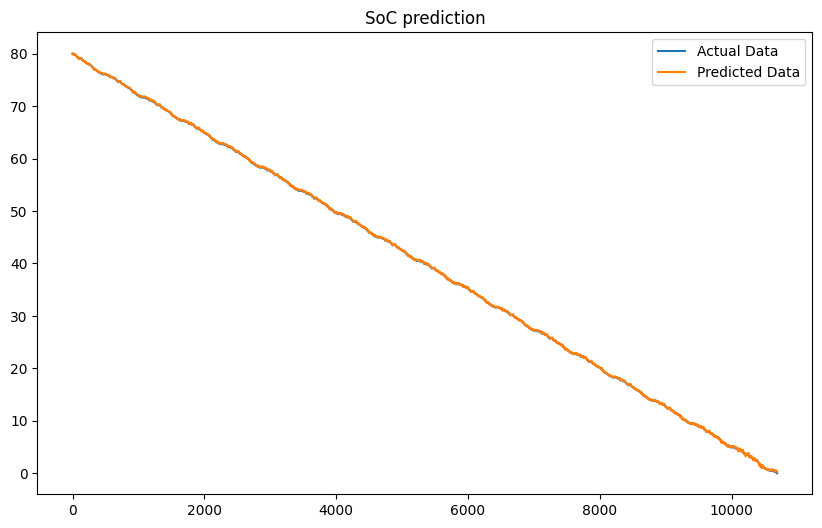

In [15]:
label_y = Y.data.numpy()

plt.figure(figsize=(10,6))
plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('SoC prediction')
#plt.xlim(0,2000)
plt.legend()
plt.show()

In [16]:
act = label_y.squeeze()
act

array([8.0000000e+01, 8.0000000e+01, 8.0000000e+01, ..., 6.7640588e-02,
       4.3735046e-02, 7.2530238e-03], dtype=float32)

In [17]:
predicted

array([79.989426  , 79.99518   , 79.99896   , ...,  0.31372803,
        0.31404865,  0.26664546], dtype=float32)

In [18]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

act = label_y.squeeze()
mape(act, predicted)

1.5676138922572136